The top half of this file contains part of the dataset content and code content, please go down to the **--Assessed Assignment 2--** section to start viewing

In [89]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [90]:
df = pd.read_csv("data/ml-latest-small/ratings.csv")

In [91]:
user_ids = df["userId"].unique().tolist()
movie_ids = df["movieId"].unique().tolist()

In [92]:
#make a dictionary mapping ids (keys) to indexes (values)
user_id_to_index = {x: i for i, x in enumerate(user_ids)}
movie_id_to_index = {x: i for i, x in enumerate(movie_ids)}

In [5]:
#make a new column in the dataframe which contains the appropriate index for each user and movie
df["user_index"] = [user_id_to_index[i] for i in df["userId"]]
df["movie_index"] = [movie_id_to_index[i] for i in df["movieId"]]

In [6]:
from sklearn.preprocessing import MinMaxScaler
##Pick the range\
df["rating"] = MinMaxScaler().fit_transform(df["rating"].values.reshape(-1, 1))

In [7]:
from sklearn.model_selection import train_test_split
#Inputs
x = df[["user_index", "movie_index"]]
#Outputs
y = df["rating"]
#Get train-test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)

In [8]:
#import library
import torch

In [9]:
#Define class and subclass torch.nn.Module
class LouisNet(torch.nn.Module):
    
    #Override __init__()
    def __init__(self):
        super().__init__()
        print("__init__ called")
    
    #Override forward()
    def forward(self, inputs):
        print("\nforwards pass (new batch)")
        print(inputs,"\n")
        #return the output (its just the input, unchanged)
        return inputs

#Make a new instance of LouisNet    
louisNet = LouisNet()
loss_fn = torch.nn.MSELoss() 

#Fake dataset
x = torch.FloatTensor([[1],[2],[3],[4]])
y = torch.FloatTensor([[2],[3],[4],[5]])

#Do a forwards pass
prediction = louisNet(x)
loss = loss_fn(prediction, y)

__init__ called

forwards pass (new batch)
tensor([[1.],
        [2.],
        [3.],
        [4.]]) 



In [69]:
class RecommenderNet(torch.nn.Module):
    def __init__(self, num_users, num_movies, embedding_size=20):
        super().__init__()
        self.user_embedding = torch.nn.Embedding(num_users, embedding_size)
        self.user_bias = torch.nn.Embedding(num_users, 1)
        self.movie_embedding = torch.nn.Embedding(num_movies, embedding_size)
        self.movie_bias = torch.nn.Embedding(num_movies, 1)
        self.sig = torch.nn.Sigmoid()

    def forward(self, inputs):
        #Split out indexes 
        user_indexes = inputs[:, 0]
        movie_indexes = inputs[:, 1]
        #Forward pass on embedding layer
        user_vector = self.user_embedding(user_indexes)
        user_bias = self.user_bias(user_indexes).flatten()
        movie_vector = self.movie_embedding(movie_indexes)
        movie_bias = self.movie_bias(movie_indexes).flatten()
        #Dot product
        dot = (user_vector * movie_vector).sum(1)
        with_bias = dot + user_bias + movie_bias
        #Activation function
        output = self.sig(with_bias)
        return output

In [11]:
#Pick Embedding size
EMBEDDING_SIZE = 16
#Make new object (calls __init__())
num_users = len(user_ids)
num_movies = len(movie_ids)
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)

In [12]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

#Make a subclass to hold our dataset (movie - user pairs (input) and a rating (label))
class MoviesDataset(Dataset):
    def __init__(self, X,y):
        self.X = torch.IntTensor(X)
        self.y = torch.FloatTensor(y)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
#Use our train - validation split to make DataLoader objects
train_dl = DataLoader(MoviesDataset(x_train.values,y_train.values), batch_size=64, shuffle=True)
validation_dl = DataLoader(MoviesDataset(x_val.values,y_val.values), batch_size=64, shuffle=True)

In [14]:
epochs = 10
#Use Mean Squared Error as a loss function
loss_fn = torch.nn.MSELoss() 
#Use the Adam algorithm to update the weights based on the loss
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [15]:
#Use a for loop to repeat for the desired number of epochs 
for i in range(epochs):
    
    model.train(True)
    
    #Use a for loop for each batch (provided by the Dataloader)
    running_loss = 0.0
    for (index, batch) in enumerate(train_dl):
        
        #Get batch 
        inputs, labels = batch
        model.zero_grad()
        
        #Forward pass
        prediction = model(inputs)
        
        #Get Loss
        loss = loss_fn(prediction, labels)
        
        #Update weights (back prop)
        loss.backward()
        optimizer.step()
        running_loss += loss
    
    avg_loss = running_loss / (index + 1)

    model.train(False)

    #Now try with the validation set (no need to update weights, just get loss)
    running_vloss = 0.0
    for index, vdata in enumerate(validation_dl):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (index + 1)
    print('Loss {} Validation Loss {}'.format(avg_loss, avg_vloss))

Loss 0.17470604181289673 Validation Loss 0.11761027574539185
Loss 0.07793352007865906 Validation Loss 0.08394395560026169
Loss 0.04924958571791649 Validation Loss 0.07135730236768723
Loss 0.037143923342227936 Validation Loss 0.06642083823680878
Loss 0.031202564015984535 Validation Loss 0.06371454894542694
Loss 0.027609053999185562 Validation Loss 0.06321537494659424
Loss 0.025171831250190735 Validation Loss 0.06280606240034103
Loss 0.02366044372320175 Validation Loss 0.06227041408419609
Loss 0.022703323513269424 Validation Loss 0.06190407648682594
Loss 0.02175804041326046 Validation Loss 0.06254275888204575


In [16]:
torch.save(model.state_dict(), 'model_weights.pth')

In [17]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

RecommenderNet(
  (user_embedding): Embedding(671, 16)
  (user_bias): Embedding(671, 1)
  (movie_embedding): Embedding(9066, 16)
  (movie_bias): Embedding(9066, 1)
  (sig): Sigmoid()
)

In [18]:
num_users, EMBEDDING_SIZE, model.user_embedding

(671, 16, Embedding(671, 16))

In [19]:
#Get the movie data so we can map back to names
movie_data = pd.read_csv("data/ml-latest-small/movies.csv")
movie_data.columns

Index(['movieId', 'title', 'genres'], dtype='object')

In [20]:
def get_top_n(user = 0, n = 10): 
    #Get Movie Names
    top_n_indexes = get_top_n_indexes(user, n)
    top_n = get_names_for_indexes(top_n_indexes)
    return top_n

def get_names_for_indexes(indexes):
    return [movie_data[movie_data["movieId"]==movie_ids[i]]["title"].item() for i in indexes]

def get_top_n_indexes(user = 0, n = 10):
    #For one user, make a pair with every movie index
    x = torch.IntTensor([[user, i] for i in np.arange(num_movies)])
    #Predict 
    predicted_ratings = model(x)
    #Get Top-N indexes
    top_n_indexes = predicted_ratings.argsort()[-n:]
    return top_n_indexes

In [21]:
#random users' top 10
get_top_n(np.random.randint(num_users))

["Bells of St. Mary's, The (1945)",
 'Tarnation (2003)',
 'Friends and Family (2001)',
 'Pirate Movie, The (1982)',
 'Burning, The (1981)',
 'Dylan Moran: Monster (2004)',
 'Robin Williams: Weapons of Self Destruction (2009)',
 '29th and Gay (2005)',
 'Clockstoppers (2002)',
 'Almost Normal (2005)']

# Assessed Assignment 2

Please remember to comment your code clearly, submit ``.ipynb`` 

## Task 1

We're going to ask you take the trained model and write the code to make two metrics - **Diversity** and **Novelty**. You should end up with **one statistic** for each that tells you something about the recommendations of the trained model based on the **whole dataset**.


#### Pro Tip

This will take quite a long time to run on the whole dataset, so start off by trying to get the code to work for **one user**, then expand to **two users**, then **every user**.

### Diversity 

This tells us what the mean diversity (inverse of the similarity, based on movie embeddings) between each film in every users Top 10 films is. 

1. Calculate every user's top 10


2. For each top 10, get the embedding for each film then use this to calculate the similarity matrix


3. Invert similarity to get the difference


4. Get mean difference for each top 10 


5. Report the mean for whole dataset (every top 10)


### Novelty 

This tells us what the mean popularity (e.g. mean rating) of the films in every users Top 10 films is 

1. Calculate every user's top 10


2. For each top 10, get the mean rating for each film (based on the original **MovieLens Small** dataset (``df = pd.read_csv("ml-latest-small/ratings.csv")``). 


3. Get the mean rating for each top 10.


4. Report the mean for the whole dataset (every top 10).



## Task 2

Using a dimensionality reduction approach (PCA? TSNE?), plot the top 30 best rated films on a 2-D graph based on their movie embeddings. Label each point with the title.

There is infact ~400 films that have an average rating of 5 (because some films have only 1 rating). Can you adjust or filter for this?

### Diversity 
### 1 Calculate every user's top 10

In [77]:
user_index

670

In [72]:
user

671

In [76]:
num_users

671

In [60]:
for user_index in range(num_users):
    # get top 10 movies for the current user
    top_movies = get_top_n(user_index, 10)
    print("User", user_index+1)
    print("Top 10 Movies:")
    for movie in top_movies:
        print(movie)
    print()


User 1
Top 10 Movies:
In the City of Sylvia (En la ciudad de Sylvia) (2007)
Talk Radio (1988)
Black Cat, White Cat (Crna macka, beli macor) (1998)
Bridge to Terabithia (2007)
Dead Man's Shoes (2004)
End, The (1978)
Touch of Evil (1958)
Tell No One (Ne le dis à personne) (2006)
Eye of the Needle (1981)
Faces of Death 4 (1990)

User 2
Top 10 Movies:
Endurance (1999)
Man with the Movie Camera, The (Chelovek s kino-apparatom) (1929)
Official Story, The (La historia oficial) (1985)
Room, The (2003)
Neighbouring Sounds (O som ao redor) (2012)
Alien Escape (1995)
Choose Me (1984)
Survive and Advance (2013)
Trailer Park Boys (1999)
Unvanquished, The (Aparajito) (1957)

User 3
Top 10 Movies:
Deadtime Stories (1987)
Down in the Delta (1998)
Hearts of the West (1975)
Secret Adventures of Tom Thumb, The (1993)
Razor's Edge, The (1946)
Salesman (1969)
White Sheik, The (Sceicco bianco, Lo) (1952)
Almost Normal (2005)
How to Lose Friends & Alienate People (2008)
Mystery Date (1991)

User 4
Top 10 Mov

User 34
Top 10 Movies:
Micmacs (Micmacs à tire-larigot) (2009)
Black Mirror (2011)
Day at the Races, A (1937)
Maya Lin: A Strong Clear Vision (1994)
Masquerade (1988)
Making a Murderer (2015)
Gigantic (A Tale of Two Johns) (2002)
They All Laughed (1981)
Alien Escape (1995)
Trailer Park Boys (1999)

User 35
Top 10 Movies:
They All Laughed (1981)
Piano Teacher, The (La pianiste) (2001)
Gambler, The (1974)
Trance (2013)
Piranha 3DD (a.k.a. Piranha DD) (2012)
Straight-Jacket (2004)
Spy Kids 3-D: Game Over (2003)
Sure Thing, The (1985)
You Can't Take It with You (1938)
Summer Hours (Heure d'été, L') (2008)

User 36
Top 10 Movies:
Package, The (1989)
Vincent (1982)
Wild Zero (2000)
Man with the Movie Camera, The (Chelovek s kino-apparatom) (1929)
Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's Tale) (2009)
Micmacs (Micmacs à tire-larigot) (2009)
Choose Me (1984)
Cops (1922)
Unvanquished, The (Aparajito) (1957)
Life of Emile Zola, The (1937)

User 37
Top 10 Movies:
Darkness Falls (2003)
Over th

User 68
Top 10 Movies:
Wild Zero (2000)
I Think I Do (1997)
Diabolique (Les diaboliques) (1955)
Vincent (1982)
Myth of the American Sleepover, The (2010)
Napoléon (1927)
Bleak House (2005)
Passage to India, A (1984)
Choose Me (1984)
They All Laughed (1981)

User 69
Top 10 Movies:
Ex Drummer (2007)
Ugetsu (Ugetsu monogatari) (1953)
Cruise, The (1998)
When We Were Kings (1996)
Queen of Versailles, The (2012)
Thirty-Two Short Films About Glenn Gould (1993)
Into the Arms of Strangers: Stories of the Kindertransport (2000)
Killer Joe (2011)
Triplets of Belleville, The (Les triplettes de Belleville) (2003)
Choose Me (1984)

User 70
Top 10 Movies:
Judgment Night (1993)
Something Borrowed (2011)
Alien Escape (1995)
Death on the Staircase (Soupçons) (2004)
Nostalghia (1983)
Misfits, The (1961)
Me Before You (2016)
Generation Kill (2008)
Mildred Pierce (2011)
Napoléon (1927)

User 71
Top 10 Movies:
Brooklyn's Finest (2010)
Lake of Fire (2006)
Almost Normal (2005)
Salesman (1969)
Golem, The (Gole

User 105
Top 10 Movies:
Vincent (1982)
I Think I Do (1997)
Unvanquished, The (Aparajito) (1957)
Good Morning, Babylon (1987)
Bedrooms & Hallways (1998)
Alien Escape (1995)
They All Laughed (1981)
Max Keeble's Big Move (2001)
Black Cat, White Cat (Crna macka, beli macor) (1998)
Life of Emile Zola, The (1937)

User 106
Top 10 Movies:
Ernest Scared Stupid (1991)
Glitter (2001)
Shakespeare-Wallah (1965)
Fifty Shades of Grey (2015)
The Island (2006)
Indestructible Man (1956)
Attack of the Giant Leeches (1959)
Ring of Terror (1962)
No Holds Barred (1989)
Sharknado 3: Oh Hell No! (2015)

User 107
Top 10 Movies:
End, The (1978)
Brown Bunny, The (2003)
Endurance (1999)
Personal Journey with Martin Scorsese Through American Movies, A (1995)
Mildred Pierce (2011)
Greystoke: The Legend of Tarzan, Lord of the Apes (1984)
'night Mother (1986)
Summer Wars (Samâ wôzu) (2009)
Big One, The (1997)
Red Firecracker, Green Firecracker (Pao Da Shuang Deng) (1994)

User 108
Top 10 Movies:
Electric Horseman, T

User 158
Top 10 Movies:
The Beatles: Eight Days a Week - The Touring Years (2016)
Mildred Pierce (2011)
Event Horizon (1997)
Death on the Staircase (Soupçons) (2004)
Ikiru (1952)
Black Mirror (2011)
Making a Murderer (2015)
Personal Journey with Martin Scorsese Through American Movies, A (1995)
Alien Escape (1995)
King of Comedy, The (1983)

User 159
Top 10 Movies:
Unvanquished, The (Aparajito) (1957)
The Lair of the White Worm (1988)
One Day in September (1999)
Endurance (1999)
Thursday (1998)
Angel on My Shoulder (1946)
Obvious Child (2014)
Wedding Gift, The (1994)
Above the Law (1988)
Shogun Assassin (1980)

User 160
Top 10 Movies:
Great Outdoors, The (1988)
Cage aux Folles, La (1978)
Action Jackson (1988)
Holy Motors (2012)
The Earrings of Madame de... (1953)
Maya Lin: A Strong Clear Vision (1994)
Prospero's Books (1991)
Mummy: Tomb of the Dragon Emperor, The (2008)
One and Only, Genuine, Original Family Band, The (1968)
They All Laughed (1981)

User 161
Top 10 Movies:
They All Lau

User 223
Top 10 Movies:
Love Is the Devil (1998)
Glen or Glenda (1953)
Big Town, The (1987)
Last Chance Harvey (2008)
Triplets of Belleville, The (Les triplettes de Belleville) (2003)
Friendly Persuasion (1956)
In This World (2002)
They Might Be Giants (1971)
Caddyshack II (1988)
Africa Screams (1949)

User 224
Top 10 Movies:
Bedrooms & Hallways (1998)
When a Stranger Calls (1979)
Stay Alive (2006)
They All Laughed (1981)
The Earrings of Madame de... (1953)
Good Morning, Babylon (1987)
End, The (1978)
Max Keeble's Big Move (2001)
Myth of the American Sleepover, The (2010)
Seducing Doctor Lewis (Grande séduction, La) (2003)

User 225
Top 10 Movies:
How to Be Single (2016)
Creature from the Black Lagoon, The (1954)
I'll Sleep When I'm Dead (2003)
El Dorado (1966)
Back Soon (2007)
Boy Crazy (2009)
Boy and His Dog, A (1975)
Angel Named Billy, An (2007)
Latter Days (2003)
On the Edge (2001)

User 226
Top 10 Movies:
Flamingo Kid, The (1984)
Gnomeo & Juliet (2011)
Dance Flick (2009)
SuperBabi

User 275
Top 10 Movies:
Last Resort (National Lampoon's Last Resort) (1994)
Dragon: The Bruce Lee Story (1993)
Emperor and the Assassin, The (Jing ke ci qin wang) (1999)
Brother, Can You Spare a Dime? (1975)
Empire of the Sun (1987)
They All Laughed (1981)
Shoot to Kill (1988)
Forsyte Saga, The (1967)
Generation Kill (2008)
Maya Lin: A Strong Clear Vision (1994)

User 276
Top 10 Movies:
Monster in a Box (1992)
Angel on My Shoulder (1946)
To Live (Huozhe) (1994)
Justice League: The Flashpoint Paradox (2013)
Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's Tale) (2009)
Country (1984)
84 Charing Cross Road (1987)
Art of War, The (2000)
Unvanquished, The (Aparajito) (1957)
Asylum (1972)

User 277
Top 10 Movies:
Wicker Man, The (1973)
Seconds (1966)
Plan 9 from Outer Space (1959)
Encounters at the End of the World (2008)
Wilbur Wants to Kill Himself (2002)
Unvanquished, The (Aparajito) (1957)
Maya Lin: A Strong Clear Vision (1994)
Love Me If You Dare (Jeux d'enfants) (2003)
Absolute Giganten (

User 315
Top 10 Movies:
Cat from Outer Space, The (1978)
Land and Freedom (Tierra y libertad) (1995)
Emperor and the Assassin, The (Jing ke ci qin wang) (1999)
Incredible Burt Wonderstone, The (2013)
Desperate Hours, The (1955)
End, The (1978)
Every Thing Will Be Fine (2015)
Solace (2015)
Undefeated (2011)
Please Don't Eat the Daisies (1960)

User 316
Top 10 Movies:
They All Laughed (1981)
I Think I Do (1997)
Rustom (2016)
Man with the Movie Camera, The (Chelovek s kino-apparatom) (1929)
Angel Named Billy, An (2007)
Sleepover (2004)
Wild Zero (2000)
Choose Me (1984)
Mystery Date (1991)
Leatherface: Texas Chainsaw Massacre III (1990)

User 317
Top 10 Movies:
Valentin (Valentín) (2002)
Yentl (1983)
Shades of Ray (2008)
Rollerball (2002)
Brewster's Millions (1985)
Everything Must Go (2010)
Prince & Me, The (2004)
Zenon: The Zequel (2001)
Leatherface: Texas Chainsaw Massacre III (1990)
Faces of Death 3 (1985)

User 318
Top 10 Movies:
First Time, The (2012)
Penny Serenade (1941)
Mo' Better 

User 361
Top 10 Movies:
Sheltering Sky, The (1990)
Unforgiven, The (1960)
Detour (1945)
I Am Trying to Break Your Heart (2002)
Drained (O cheiro do Ralo) (2006)
Unvanquished, The (Aparajito) (1957)
Brother, Can You Spare a Dime? (1975)
Grey Gardens (1975)
Endurance (1999)
Past, The (Le passé) (2013)

User 362
Top 10 Movies:
Robin Williams: Weapons of Self Destruction (2009)
Phantom of the Paradise (1974)
Black Cat, White Cat (Crna macka, beli macor) (1998)
Decalogue, The (Dekalog) (1989)
Riding Giants (2004)
Touch of Pink (2004)
Dead Man's Shoes (2004)
Allan Quatermain and the Lost City of Gold (1987)
Dylan Moran: Monster (2004)
I Think I Do (1997)

User 363
Top 10 Movies:
Germany Year Zero (Germania anno zero) (Deutschland im Jahre Null) (1948)
Hitch-Hiker, The (1953)
Black Cat, White Cat (Crna macka, beli macor) (1998)
Dr. Mabuse: The Gambler (Dr. Mabuse, der Spieler) (1922)
10 Attitudes (2001)
Dead Man's Shoes (2004)
'night Mother (1986)
Endurance (1999)
Wicker Man, The (1973)
Unvan

User 401
Top 10 Movies:
Boy and His Dog, A (1975)
Mystery Date (1991)
Animal Crackers (1930)
Emperor's New Clothes, The (2001)
Clockstoppers (2002)
16 Wishes (2010)
Day the Sun Turned Cold, The (Tianguo niezi) (1994)
The Brave Little Toaster Goes to Mars (1998)
Curiosity of Chance, The (2006)
On the Edge (2001)

User 402
Top 10 Movies:
Mirror, The (Zerkalo) (1975)
Dr. Mabuse: The Gambler (Dr. Mabuse, der Spieler) (1922)
Micmacs (Micmacs à tire-larigot) (2009)
Faraway, So Close (In weiter Ferne, so nah!) (1993)
Manson Family, The (2003)
Aria (1987)
I Think I Do (1997)
Wild Zero (2000)
No Holds Barred (1989)
Clash of the Titans (2010)

User 403
Top 10 Movies:
State of Things, The (Stand der Dinge, Der) (1982)
Stay Alive (2006)
MirrorMask (2005)
Nightcrawler (2014)
Dear Zachary: A Letter to a Son About His Father (2008)
Prince & Me, The (2004)
Seducing Doctor Lewis (Grande séduction, La) (2003)
Everything Must Go (2010)
Tyler Perry's Madea Goes to Jail (2009)
Steamboat Willie (1928)

User

User 441
Top 10 Movies:
Secrets & Lies (1996)
Cadillac Man (1990)
Hard Way, The (1943)
Nim's Island (2008)
Sharknado 3: Oh Hell No! (2015)
Angel on My Shoulder (1946)
Tell No One (Ne le dis à personne) (2006)
Mummy's Ghost, The (1944)
Art of War, The (2000)
First Time, The (2012)

User 442
Top 10 Movies:
Lover, The (Amant, L') (1992)
Seconds (1966)
Love and Basketball (2000)
No Direction Home: Bob Dylan (2005)
Unvanquished, The (Aparajito) (1957)
Dead Man's Shoes (2004)
Son of Frankenstein (1939)
Black Cat, White Cat (Crna macka, beli macor) (1998)
Leatherface: Texas Chainsaw Massacre III (1990)
Myth of the American Sleepover, The (2010)

User 443
Top 10 Movies:
Decline of Western Civilization, The (1981)
God Bless America (2011)
Civil War, The (1990)
Uncommon Valor (1983)
Return of the Secaucus 7 (1980)
The Beatles: Eight Days a Week - The Touring Years (2016)
To Be and to Have (Être et avoir) (2002)
Mildred Pierce (2011)
Event Horizon (1997)
Sammy and Rosie Get Laid (1987)

User 444


User 480
Top 10 Movies:
Under the Same Moon (Misma luna, La) (2007)
Life of Emile Zola, The (1937)
Choose Me (1984)
Razor's Edge, The (1946)
Bobby Deerfield (1977)
Myth of the American Sleepover, The (2010)
Above the Law (1988)
Angel Named Billy, An (2007)
Man with the Movie Camera, The (Chelovek s kino-apparatom) (1929)
Leatherface: Texas Chainsaw Massacre III (1990)

User 481
Top 10 Movies:
Room, The (2003)
Seducing Doctor Lewis (Grande séduction, La) (2003)
Wild Zero (2000)
Experience Preferred... But Not Essential (1982)
Max Keeble's Big Move (2001)
Dr. Jekyll and Mr. Hyde (1941)
Green for Danger (1946)
Eclisse, L' (Eclipse) (1962)
Brother, Can You Spare a Dime? (1975)
The Earrings of Madame de... (1953)

User 482
Top 10 Movies:
Places in the Heart (1984)
Bobby Deerfield (1977)
They All Laughed (1981)
Trailer Park Boys (1999)
Faraway, So Close (In weiter Ferne, so nah!) (1993)
Punch-Drunk Love (2002)
Am Ende eiens viel zu kurzen Tages (Death of a superhero) (2011)
Peanuts Movie, Th

User 517
Top 10 Movies:
Taste of Cherry (Ta'm e guilass) (1997)
Mirror, The (Zerkalo) (1975)
Long Riders, The (1980)
Woman on the Beach (Haebyeonui yeoin) (2006)
Steamboat Bill, Jr. (1928)
Like Father, Like Son (Soshite chichi ni naru) (2013)
Benji (1974)
Bobby (2006)
Blackmail (1929)
Kwaidan (Kaidan) (1964)

User 518
Top 10 Movies:
Past, The (Le passé) (2013)
Land and Freedom (Tierra y libertad) (1995)
How to Make Love to a Woman (2010)
Big Town, The (1987)
Angus, Thongs and Perfect Snogging (2008)
Package, The (1989)
Kind Hearts and Coronets (1949)
Crimson Pirate, The (1952)
Defender, The (a.k.a. Bodyguard from Beijing, The) (Zhong Nan Hai bao biao) (1994)
Faraway, So Close (In weiter Ferne, so nah!) (1993)

User 519
Top 10 Movies:
Angel Named Billy, An (2007)
Bill Hicks: Revelations (1993)
Hollywood Ending (2002)
Play House, The (1921)
Life Is Sweet (1990)
George Carlin: It's Bad for Ya! (2008)
Brother, Can You Spare a Dime? (1975)
Fawlty Towers (1975-1979)
Sabotage (1936)
They All 

User 551
Top 10 Movies:
Erik the Viking (1989)
Bedrooms & Hallways (1998)
24: Redemption (2008)
Mildred Pierce (2011)
'night Mother (1986)
War Room (2015)
I Think I Do (1997)
End, The (1978)
20,000 Leagues Under the Sea (1916)
Endurance (1999)

User 552
Top 10 Movies:
Unvanquished, The (Aparajito) (1957)
Z Channel: A Magnificent Obsession (2004)
Shogun Assassin (1980)
Angel on My Shoulder (1946)
Apartment 143 (2011)
Flicka (2006)
Lost Highway (1997)
Passage to India, A (1984)
Play House, The (1921)
Choose Me (1984)

User 553
Top 10 Movies:
On the Edge (2001)
Mothra (Mosura) (1961)
Picnic at Hanging Rock (1975)
Dylan Moran: Monster (2004)
Passage to India, A (1984)
20,000 Leagues Under the Sea (1916)
Mama (2013)
Lights in the Dusk (Laitakaupungin valot) (2006)
Prime Cut (1972)
I Think I Do (1997)

User 554
Top 10 Movies:
Neighbouring Sounds (O som ao redor) (2012)
Unvanquished, The (Aparajito) (1957)
Elizabeth: The Golden Age (2007)
Am Ende eiens viel zu kurzen Tages (Death of a superhe

User 578
Top 10 Movies:
Pajama Party (1964)
Allan Quatermain and the Lost City of Gold (1987)
Because I Said So (2007)
Stay Alive (2006)
Hands on a Hard Body (1996)
Faces of Death 3 (1985)
Mysterious Skin (2004)
Innocence (2000)
Excision (2012)
24: Redemption (2008)

User 579
Top 10 Movies:
Sharknado 3: Oh Hell No! (2015)
Solace (2015)
Farewell My Concubine (Ba wang bie ji) (1993)
Faraway, So Close (In weiter Ferne, so nah!) (1993)
Garfield: A Tail of Two Kitties (2006)
Sweet Hereafter, The (1997)
Love Me If You Dare (Jeux d'enfants) (2003)
Return of the Living Dead, The (1985)
Joyful Noise (2012)
Rivers and Tides (2001)

User 580
Top 10 Movies:
Tom Jones (1963)
Wild Zero (2000)
Endurance (1999)
Fox and His Friends (Faustrecht der Freiheit) (1975)
I Think I Do (1997)
Micmacs (Micmacs à tire-larigot) (2009)
Manson Family, The (2003)
Myth of the American Sleepover, The (2010)
Good Morning, Babylon (1987)
Unvanquished, The (Aparajito) (1957)

User 581
Top 10 Movies:
And God Created Woman 

User 605
Top 10 Movies:
Hitch-Hiker, The (1953)
Crimson Pirate, The (1952)
Cruise, The (1998)
Rosewood (1997)
Tiger Orange (2014)
Leatherface: Texas Chainsaw Massacre III (1990)
Dr. Mabuse: The Gambler (Dr. Mabuse, der Spieler) (1922)
10 Attitudes (2001)
I Think I Do (1997)
Dylan Moran: Monster (2004)

User 606
Top 10 Movies:
Last Resort (National Lampoon's Last Resort) (1994)
John Q (2002)
Sharknado 3: Oh Hell No! (2015)
Ikiru (1952)
Watchmen: Tales of the Black Freighter (2009)
Johnny English (2003)
The Face of an Angel (2015)
Heaven Knows, Mr. Allison (1957)
Glitter (2001)
My Life Without Me (2003)

User 607
Top 10 Movies:
Mildred Pierce (2011)
How to Be Single (2016)
My Life Without Me (2003)
20,000 Leagues Under the Sea (1916)
Ikiru (1952)
Prime Cut (1972)
Sgt. Pepper's Lonely Hearts Club Band (1978)
Leatherface: Texas Chainsaw Massacre III (1990)
Fallen (1998)
Micmacs (Micmacs à tire-larigot) (2009)

User 608
Top 10 Movies:
Curious George (2006)
End, The (1978)
Mummy's Ghost, The

User 644
Top 10 Movies:
Land of Silence and Darkness (Land des Schweigens und der Dunkelheit) (1971)
Dr. Jekyll and Mr. Hyde (1941)
Chaser, The (Chugyeogja) (2008)
Wackness, The (2008)
No Man's Land (2001)
Cops (1922)
Fawlty Towers (1975-1979)
Looney, Looney, Looney Bugs Bunny Movie, The (1981)
The Earrings of Madame de... (1953)
Seducing Doctor Lewis (Grande séduction, La) (2003)

User 645
Top 10 Movies:
Kind Hearts and Coronets (1949)
Stargate: The Ark of Truth (2008)
Cyclo (Xich lo) (1995)
Switch, The (2010)
Next (2007)
Rosewood (1997)
Dylan Moran: Monster (2004)
White Stripes Under Great White Northern Lights, The (2009)
How to Make Love to a Woman (2010)
Crimson Pirate, The (1952)

User 646
Top 10 Movies:
Trip, The (2002)
Wicker Man, The (1973)
Our Hospitality (1923)
Zulu (1964)
And the Band Played On (1993)
Eighteen (2005)
Tiger Orange (2014)
10 Attitudes (2001)
Touch of Pink (2004)
Clockstoppers (2002)

User 647
Top 10 Movies:
Apollo 13: To the Edge and Back (1994)
Unvanquished,

### 2 For each top 10, get the embedding for each film then use this to calculate the similarity matrix

In [206]:
#here I want to define the calculate_similarity_matrix first, and then calculate the result in the next step
def calculate_similarity_matrix(user, n):
    top_movie_indexes = get_top_n_indexes(user, n)
    movie_embeddings = model.movie_embedding(torch.LongTensor(top_movie_indexes)).detach().numpy()

    similarity_matrix = cosine_similarity(movie_embeddings)
    return similarity_matrix

### 3 Invert similarity to get the difference

In [84]:
# using the calculate_similarity_matrix above
def calculate_difference_matrix(user=0, n=10):
    similarity_matrix = calculate_similarity_matrix(user, n)
    difference_matrix = 1 - similarity_matrix
    return difference_matrix

def calculate_difference_matrix_for_all_users(n=10):
    difference_matrices = []
    for user in user_ids:
        difference_matrix = calculate_difference_matrix(user-1, n)
        difference_matrices.append(difference_matrix)
    return difference_matrices

# example usage for calculating difference matrices for all users' top 10 movies
difference_matrices = calculate_difference_matrix_for_all_users(n=10)
for i, user in enumerate(user_ids):
    print("Difference matrix for top 10 movies of user", user)
    print(difference_matrices[i])
    print()


Difference matrix for top 10 movies of user 1
[[ 5.9604645e-08  9.9868441e-01  5.8789754e-01  7.4881965e-01
   7.3187399e-01  9.9944758e-01  7.6264548e-01  6.2405068e-01
   6.8773103e-01  6.7836416e-01]
 [ 9.9868441e-01  0.0000000e+00  7.3634243e-01  6.3716263e-01
   1.0460829e+00  2.7981830e-01  5.1161277e-01  8.3258897e-01
   8.0439812e-01  5.9807384e-01]
 [ 5.8789754e-01  7.3634243e-01 -1.1920929e-07  1.0794958e+00
   6.1872673e-01  6.4568090e-01  7.7556098e-01  6.5917802e-01
   7.3174822e-01  6.0936880e-01]
 [ 7.4881965e-01  6.3716263e-01  1.0794958e+00 -1.1920929e-07
   9.9437463e-01  4.1819227e-01  8.7007201e-01  7.4133945e-01
   5.5043131e-01  5.1436448e-01]
 [ 7.3187399e-01  1.0460829e+00  6.1872673e-01  9.9437463e-01
   0.0000000e+00  1.1527348e+00  6.0589290e-01  7.2769189e-01
   7.5804645e-01  5.4132462e-01]
 [ 9.9944758e-01  2.7981830e-01  6.4568090e-01  4.1819227e-01
   1.1527348e+00 -1.1920929e-07  9.1065377e-01  1.0253739e+00
   8.4855747e-01  6.6591871e-01]
 [ 7.6264548

   7.4906790e-01  5.9604645e-08]]

Difference matrix for top 10 movies of user 531
[[ 0.0000000e+00  4.3044215e-01  6.3876200e-01  6.1303627e-01
   2.3839247e-01  7.0747161e-01  5.3194475e-01  6.4309794e-01
   7.9091132e-01  5.4677832e-01]
 [ 4.3044215e-01 -1.1920929e-07  5.9765661e-01  1.0712708e+00
   5.1033103e-01  8.4717977e-01  7.4155599e-01  5.7664376e-01
   9.5383066e-01  2.3361492e-01]
 [ 6.3876200e-01  5.9765661e-01 -1.1920929e-07  5.9676367e-01
   5.1094222e-01  4.1692799e-01  6.7662525e-01  6.2812555e-01
   5.6189013e-01  8.1407505e-01]
 [ 6.1303627e-01  1.0712708e+00  5.9676367e-01  0.0000000e+00
   5.1125026e-01  5.6879306e-01  5.0476766e-01  5.5454195e-01
   5.3560108e-01  8.9031535e-01]
 [ 2.3839247e-01  5.1033103e-01  5.1094222e-01  5.1125026e-01
  -1.1920929e-07  7.1817118e-01  6.4058149e-01  7.2289586e-01
   4.7471243e-01  5.2373970e-01]
 [ 7.0747161e-01  8.4717977e-01  4.1692799e-01  5.6879306e-01
   7.1817118e-01 -1.1920929e-07  7.3377275e-01  4.8877364e-01
   4.217

### 4 Get mean difference for each top 10

In [86]:
# define calculate_mean_difference
def calculate_mean_difference(user=0, n=10):
    difference_matrix = calculate_difference_matrix(user, n)
    mean_difference = np.mean(difference_matrix)
    return mean_difference

# define calculate_mean_difference_for_all_users
def calculate_mean_difference_for_all_users(n=10):
    mean_differences = []
    for user in user_ids:
        mean_difference = calculate_mean_difference(user-1, n)
        mean_differences.append(mean_difference)
    return mean_differences

# example usage for calculating mean differences for all users' top 10 movies
mean_differences = calculate_mean_difference_for_all_users(n=10)
for i, user in enumerate(user_ids):
    print("Mean difference for top 10 movies of user", user)
    print(mean_differences[i])
    print()


Mean difference for top 10 movies of user 1
0.6297481

Mean difference for top 10 movies of user 2
0.6665781

Mean difference for top 10 movies of user 3
0.6143896

Mean difference for top 10 movies of user 4
0.5659431

Mean difference for top 10 movies of user 5
0.55230355

Mean difference for top 10 movies of user 6
0.5877245

Mean difference for top 10 movies of user 7
0.6958529

Mean difference for top 10 movies of user 8
0.6547612

Mean difference for top 10 movies of user 9
0.57806456

Mean difference for top 10 movies of user 10
0.47567332

Mean difference for top 10 movies of user 11
0.60668796

Mean difference for top 10 movies of user 12
0.6240514

Mean difference for top 10 movies of user 13
0.61755496

Mean difference for top 10 movies of user 14
0.5388196

Mean difference for top 10 movies of user 15
0.5926764

Mean difference for top 10 movies of user 16
0.49836257

Mean difference for top 10 movies of user 17
0.5638654

Mean difference for top 10 movies of user 18
0.6202

### 5 Report the mean for whole dataset (every top 10)


In [88]:
#define calculate_mean_difference_for_dataset
def calculate_mean_difference_for_dataset(n=10):
    mean_differences = []
    for user in user_ids:
        mean_difference = calculate_mean_difference(user-1, n)
        mean_differences.append(mean_difference)
    mean_difference_dataset = np.mean(mean_differences)
    return mean_difference_dataset

# example usage for calculating the mean difference for the entire dataset
mean_difference_dataset = calculate_mean_difference_for_dataset(n=10)
print("Mean difference for the entire dataset (all users' top 10 movies):")
print(mean_difference_dataset) #here we get result

Mean difference for the entire dataset (all users' top 10 movies):
0.6051821


### Novelty
### 1 Calculate every user's top 10

### 2 For each top 10, get the mean rating for each film


In [145]:
# define get_mean_ratings_for_top_10
def get_mean_ratings_for_top_10():
    mean_ratings_top_10 = {}

    for user_id in user_ids:
        top_n_indexes = get_top_n_indexes(user_id-1, 10)
        movie_ids_top_10 = [movie_ids[i] for i in top_n_indexes]
        top_10_movies = df[df["movieId"].isin(movie_ids_top_10)]
        mean_ratings = top_10_movies.groupby("movieId")["rating"].mean().to_dict()
        mean_ratings_top_10[user_id] = mean_ratings

    return mean_ratings_top_10

# get the mean ratings for each film in every user's top 10
mean_ratings_top_10 = get_mean_ratings_for_top_10()

# print the mean ratings for each film in every user's top 10
for user_id, mean_ratings in mean_ratings_top_10.items():
    print("User ID:", user_id)
    for movie_id, mean_rating in mean_ratings.items():
        movie_title = movie_data[movie_data["movieId"] == movie_id]["title"].item()
        print("Movie ID:", movie_id)
        print("Movie Title:", movie_title)
        print("Mean Rating:", mean_rating)
        print()


User ID: 1
Movie ID: 1248
Movie Title: Touch of Evil (1958)
Mean Rating: 4.2368421052631575

Movie ID: 2843
Movie Title: Black Cat, White Cat (Crna macka, beli macor) (1998)
Mean Rating: 4.666666666666667

Movie ID: 4009
Movie Title: Talk Radio (1988)
Mean Rating: 4.0

Movie ID: 4201
Movie Title: End, The (1978)
Mean Rating: 5.0

Movie ID: 5732
Movie Title: Eye of the Needle (1981)
Mean Rating: 4.5

Movie ID: 5737
Movie Title: Faces of Death 4 (1990)
Mean Rating: 2.0

Movie ID: 40412
Movie Title: Dead Man's Shoes (2004)
Mean Rating: 4.75

Movie ID: 50601
Movie Title: Bridge to Terabithia (2007)
Mean Rating: 2.625

Movie ID: 54372
Movie Title: Tell No One (Ne le dis à personne) (2006)
Mean Rating: 4.5

Movie ID: 61206
Movie Title: In the City of Sylvia (En la ciudad de Sylvia) (2007)
Mean Rating: 4.5

User ID: 2
Movie ID: 1692
Movie Title: Alien Escape (1995)
Mean Rating: 5.0

Movie ID: 2627
Movie Title: Endurance (1999)
Mean Rating: 5.0

Movie ID: 3816
Movie Title: Official Story, The 

Movie ID: 26501
Movie Title: Choose Me (1984)
Mean Rating: 5.0

Movie ID: 32840
Movie Title: Vincent (1982)
Mean Rating: 4.5

Movie ID: 40226
Movie Title: Wild Zero (2000)
Mean Rating: 5.0

Movie ID: 73290
Movie Title: Hachiko: A Dog's Story (a.k.a. Hachi: A Dog's Tale) (2009)
Mean Rating: 4.5

Movie ID: 76173
Movie Title: Micmacs (Micmacs à tire-larigot) (2009)
Mean Rating: 4.5

Movie ID: 83411
Movie Title: Cops (1922)
Mean Rating: 5.0

User ID: 37
Movie ID: 4630
Movie Title: No Holds Barred (1989)
Mean Rating: 3.0

Movie ID: 6040
Movie Title: Darkness Falls (2003)
Mean Rating: 1.6666666666666667

Movie ID: 7016
Movie Title: Over the Top (1987)
Mean Rating: 1.0

Movie ID: 55294
Movie Title: Weirdsville (2007)
Mean Rating: 2.5

Movie ID: 68965
Movie Title: Dance Flick (2009)
Mean Rating: 0.5

Movie ID: 73386
Movie Title: Staten Island (2009)
Mean Rating: 1.5

Movie ID: 80864
Movie Title: You Will Meet a Tall Dark Stranger (2010)
Mean Rating: 3.25

Movie ID: 94896
Movie Title: Bernie (2

Movie Title: Aguirre: The Wrath of God (Aguirre, der Zorn Gottes) (1972)
Mean Rating: 4.333333333333333

Movie ID: 7238
Movie Title: Ashes and Diamonds (Popiól i diament) (1958)
Mean Rating: 4.0

Movie ID: 27826
Movie Title: Touch of Pink (2004)
Mean Rating: 5.0

Movie ID: 82608
Movie Title: Zerophilia (2005)
Mean Rating: 5.0

Movie ID: 103731
Movie Title: Angel Named Billy, An (2007)
Mean Rating: 5.0

Movie ID: 120805
Movie Title: Robin Williams: Weapons of Self Destruction (2009)
Mean Rating: 5.0

Movie ID: 140745
Movie Title: 10 Attitudes (2001)
Mean Rating: 5.0

Movie ID: 141124
Movie Title: FAQs (2005)
Mean Rating: 5.0

User ID: 67
Movie ID: 279
Movie Title: My Family (1995)
Mean Rating: 2.875

Movie ID: 845
Movie Title: Day the Sun Turned Cold, The (Tianguo niezi) (1994)
Mean Rating: 5.0

Movie ID: 3920
Movie Title: Faraway, So Close (In weiter Ferne, so nah!) (1993)
Mean Rating: 3.5

Movie ID: 5264
Movie Title: Clockstoppers (2002)
Mean Rating: 5.0

Movie ID: 5847
Movie Title: R

Movie ID: 73106
Movie Title: American Pie Presents: The Book of Love (American Pie 7: The Book of Love) (2009)
Mean Rating: 2.1666666666666665

Movie ID: 74727
Movie Title: Gentlemen of Fortune (Dzhentlmeny udachi) (1972)
Mean Rating: 5.0

User ID: 98
Movie ID: 956
Movie Title: Penny Serenade (1941)
Mean Rating: 3.1666666666666665

Movie ID: 4731
Movie Title: Innocence (2000)
Mean Rating: 5.0

Movie ID: 6832
Movie Title: Regarding Henry (1991)
Mean Rating: 3.125

Movie ID: 7375
Movie Title: Prince & Me, The (2004)
Mean Rating: 4.333333333333333

Movie ID: 26501
Movie Title: Choose Me (1984)
Mean Rating: 5.0

Movie ID: 34552
Movie Title: Girl in the Café, The (2005)
Mean Rating: 3.75

Movie ID: 34583
Movie Title: Prime Cut (1972)
Mean Rating: 3.0

Movie ID: 58649
Movie Title: Napoléon (1927)
Mean Rating: 5.0

Movie ID: 78729
Movie Title: 24: Redemption (2008)
Mean Rating: 2.25

Movie ID: 93721
Movie Title: Jiro Dreams of Sushi (2011)
Mean Rating: 3.75

User ID: 99
Movie ID: 1264
Movie T

Movie ID: 3757
Movie Title: Asylum (1972)
Mean Rating: 5.0

Movie ID: 5673
Movie Title: Punch-Drunk Love (2002)
Mean Rating: 3.5208333333333335

Movie ID: 8607
Movie Title: Tokyo Godfathers (2003)
Mean Rating: 3.8333333333333335

Movie ID: 8642
Movie Title: Sleepover (2004)
Mean Rating: 3.0

Movie ID: 90061
Movie Title: Myth of the American Sleepover, The (2010)
Mean Rating: 5.0

Movie ID: 106441
Movie Title: Book Thief, The (2013)
Mean Rating: 4.25

User ID: 134
Movie ID: 2461
Movie Title: Leatherface: Texas Chainsaw Massacre III (1990)
Mean Rating: 3.25

Movie ID: 6433
Movie Title: Man with the Movie Camera, The (Chelovek s kino-apparatom) (1929)
Mean Rating: 3.8333333333333335

Movie ID: 6669
Movie Title: Ikiru (1952)
Mean Rating: 4.75

Movie ID: 7116
Movie Title: Diabolique (Les diaboliques) (1955)
Mean Rating: 4.7

Movie ID: 26501
Movie Title: Choose Me (1984)
Mean Rating: 5.0

Movie ID: 34583
Movie Title: Prime Cut (1972)
Mean Rating: 3.0

Movie ID: 40226
Movie Title: Wild Zero (

Movie ID: 309
Movie Title: Red Firecracker, Green Firecracker (Pao Da Shuang Deng) (1994)
Mean Rating: 5.0

Movie ID: 2627
Movie Title: Endurance (1999)
Mean Rating: 5.0

Movie ID: 3112
Movie Title: 'night Mother (1986)
Mean Rating: 5.0

Movie ID: 4754
Movie Title: Wicker Man, The (1973)
Mean Rating: 4.0

Movie ID: 4799
Movie Title: It's a Mad, Mad, Mad, Mad World (1963)
Mean Rating: 3.7857142857142856

Movie ID: 5899
Movie Title: Zulu (1964)
Mean Rating: 4.0

Movie ID: 49280
Movie Title: Bobby (2006)
Mean Rating: 5.0

Movie ID: 71494
Movie Title: Haunted World of El Superbeasto, The (2009)
Mean Rating: 4.0

Movie ID: 84506
Movie Title: Silent Souls (Ovsyanki) (2010)
Mean Rating: 3.5

Movie ID: 91673
Movie Title: Albert Nobbs (2011)
Mean Rating: 5.0

User ID: 170
Movie ID: 392
Movie Title: Secret Adventures of Tom Thumb, The (1993)
Mean Rating: 2.6666666666666665

Movie ID: 1933
Movie Title: Life of Emile Zola, The (1937)
Mean Rating: 5.0

Movie ID: 2438
Movie Title: Outside Ozona (199

Mean Rating: 2.0

Movie ID: 3920
Movie Title: Faraway, So Close (In weiter Ferne, so nah!) (1993)
Mean Rating: 3.5

Movie ID: 4274
Movie Title: Cleopatra (1963)
Mean Rating: 2.5

Movie ID: 5047
Movie Title: Kung Pow: Enter the Fist (2002)
Mean Rating: 2.0

Movie ID: 5866
Movie Title: They All Laughed (1981)
Mean Rating: 5.0

Movie ID: 26480
Movie Title: Raiders of Atlantis, The (1983)
Mean Rating: 3.0

Movie ID: 71390
Movie Title: Not Quite Hollywood: The Wild, Untold Story of Ozploitation! (2008)
Mean Rating: 5.0

Movie ID: 76173
Movie Title: Micmacs (Micmacs à tire-larigot) (2009)
Mean Rating: 4.5

Movie ID: 96467
Movie Title: Sleepwalk with Me (2012)
Mean Rating: 4.25

Movie ID: 101283
Movie Title: Incredible Burt Wonderstone, The (2013)
Mean Rating: 2.5

User ID: 194
Movie ID: 449
Movie Title: Fear of a Black Hat (1994)
Mean Rating: 3.5

Movie ID: 632
Movie Title: Land and Freedom (Tierra y libertad) (1995)
Mean Rating: 4.5

Movie ID: 1934
Movie Title: You Can't Take It with You (1

Movie ID: 1326
Movie Title: Amityville II: The Possession (1982)
Mean Rating: 2.6666666666666665

Movie ID: 2523
Movie Title: Rollercoaster (1977)
Mean Rating: 2.6666666666666665

Movie ID: 3757
Movie Title: Asylum (1972)
Mean Rating: 5.0

Movie ID: 3930
Movie Title: Creature from the Black Lagoon, The (1954)
Mean Rating: 3.4

Movie ID: 4670
Movie Title: Stepfather, The (1987)
Mean Rating: 3.25

Movie ID: 5193
Movie Title: Jazz Singer, The (1980)
Mean Rating: 3.6666666666666665

Movie ID: 6770
Movie Title: My Life Without Me (2003)
Mean Rating: 4.25

Movie ID: 8138
Movie Title: Attack of the Giant Leeches (1959)
Mean Rating: 1.75

Movie ID: 92665
Movie Title: For a Good Time, Call... (2012)
Mean Rating: 2.5

Movie ID: 102720
Movie Title: Epic (2013)
Mean Rating: 3.0

User ID: 228
Movie ID: 2928
Movie Title: Razor's Edge, The (1984)
Mean Rating: 3.6666666666666665

Movie ID: 4396
Movie Title: Cannonball Run, The (1981)
Mean Rating: 3.5

Movie ID: 5617
Movie Title: Secretary (2002)
Mean 

Movie Title: On the Edge (2001)
Mean Rating: 5.0

Movie ID: 5765
Movie Title: Looney, Looney, Looney Bugs Bunny Movie, The (1981)
Mean Rating: 5.0

Movie ID: 7055
Movie Title: Swing Time (1936)
Mean Rating: 3.5

Movie ID: 7260
Movie Title: Latter Days (2003)
Mean Rating: 5.0

Movie ID: 8642
Movie Title: Sleepover (2004)
Mean Rating: 3.0

Movie ID: 33296
Movie Title: Buying the Cow (2002)
Mean Rating: 3.0

Movie ID: 67504
Movie Title: Land of Silence and Darkness (Land des Schweigens und der Dunkelheit) (1971)
Mean Rating: 5.0

Movie ID: 103731
Movie Title: Angel Named Billy, An (2007)
Mean Rating: 5.0

User ID: 261
Movie ID: 1859
Movie Title: Taste of Cherry (Ta'm e guilass) (1997)
Mean Rating: 5.0

Movie ID: 2267
Movie Title: Mortal Thoughts (1991)
Mean Rating: 4.5

Movie ID: 3920
Movie Title: Faraway, So Close (In weiter Ferne, so nah!) (1993)
Mean Rating: 3.5

Movie ID: 4724
Movie Title: On the Edge (2001)
Mean Rating: 5.0

Movie ID: 5229
Movie Title: I Think I Do (1997)
Mean Rating

Movie ID: 125916
Movie Title: Fifty Shades of Grey (2015)
Mean Rating: 0.5

User ID: 290
Movie ID: 1933
Movie Title: Life of Emile Zola, The (1937)
Mean Rating: 5.0

Movie ID: 2443
Movie Title: Playing by Heart (1998)
Mean Rating: 4.0

Movie ID: 3737
Movie Title: Lonely Are the Brave (1962)
Mean Rating: 5.0

Movie ID: 4140
Movie Title: North Shore (1987)
Mean Rating: 5.0

Movie ID: 5866
Movie Title: They All Laughed (1981)
Mean Rating: 5.0

Movie ID: 7236
Movie Title: Boy and His Dog, A (1975)
Mean Rating: 3.0

Movie ID: 7260
Movie Title: Latter Days (2003)
Mean Rating: 5.0

Movie ID: 70697
Movie Title: G-Force (2009)
Mean Rating: 1.75

Movie ID: 127728
Movie Title: Back Soon (2007)
Mean Rating: 5.0

Movie ID: 140763
Movie Title: Boy Crazy (2009)
Mean Rating: 5.0

User ID: 291
Movie ID: 2843
Movie Title: Black Cat, White Cat (Crna macka, beli macor) (1998)
Mean Rating: 4.666666666666667

Movie ID: 5915
Movie Title: Victory (a.k.a. Escape to Victory) (1981)
Mean Rating: 4.25

Movie ID: 

Movie ID: 43869
Movie Title: Curious George (2006)
Mean Rating: 4.0

Movie ID: 80166
Movie Title: Switch, The (2010)
Mean Rating: 2.75

Movie ID: 90345
Movie Title: Thing, The (2011)
Mean Rating: 3.5

Movie ID: 90870
Movie Title: Trespass (2011)
Mean Rating: 0.5

Movie ID: 160565
Movie Title: The Purge: Election Year (2016)
Mean Rating: 2.0

User ID: 323
Movie ID: 250
Movie Title: Heavyweights (Heavy Weights) (1995)
Mean Rating: 3.25

Movie ID: 1331
Movie Title: Audrey Rose (1977)
Mean Rating: 2.3333333333333335

Movie ID: 2748
Movie Title: Allan Quatermain and the Lost City of Gold (1987)
Mean Rating: 2.7

Movie ID: 4754
Movie Title: Wicker Man, The (1973)
Mean Rating: 4.0

Movie ID: 7924
Movie Title: Stray Dog (Nora inu) (1949)
Mean Rating: 4.5

Movie ID: 62378
Movie Title: Magicians (2007)
Mean Rating: 3.0

Movie ID: 76173
Movie Title: Micmacs (Micmacs à tire-larigot) (2009)
Mean Rating: 4.5

Movie ID: 79824
Movie Title: Babies (Bébé(s)) (2010)
Mean Rating: 4.0

Movie ID: 94896
Movi

Movie Title: Hollywood Ending (2002)
Mean Rating: 3.5

Movie ID: 8572
Movie Title: Littlest Rebel, The (1935)
Mean Rating: 4.5

Movie ID: 62718
Movie Title: Angus, Thongs and Perfect Snogging (2008)
Mean Rating: 4.5

Movie ID: 66090
Movie Title: Eden Lake (2008)
Mean Rating: 3.75

Movie ID: 94466
Movie Title: Black Mirror (2011)
Mean Rating: 3.7142857142857144

Movie ID: 98122
Movie Title: Indie Game: The Movie (2012)
Mean Rating: 2.25

Movie ID: 98933
Movie Title: Yossi (Ha-Sippur Shel Yossi) (2012)
Mean Rating: 5.0

Movie ID: 163949
Movie Title: The Beatles: Eight Days a Week - The Touring Years (2016)
Mean Rating: 5.0

User ID: 358
Movie ID: 2837
Movie Title: Bedrooms & Hallways (1998)
Mean Rating: 5.0

Movie ID: 3038
Movie Title: Face in the Crowd, A (1957)
Mean Rating: 5.0

Movie ID: 5765
Movie Title: Looney, Looney, Looney Bugs Bunny Movie, The (1981)
Mean Rating: 5.0

Movie ID: 7096
Movie Title: Rivers and Tides (2001)
Mean Rating: 4.0

Movie ID: 8121
Movie Title: Seducing Docto

Movie ID: 2330
Movie Title: Hands on a Hard Body (1996)
Mean Rating: 4.666666666666667

Movie ID: 3695
Movie Title: Toxic Avenger Part III: The Last Temptation of Toxie, The (1989)
Mean Rating: 2.5

Movie ID: 4543
Movie Title: Shoot to Kill (1988)
Mean Rating: 3.0

Movie ID: 6773
Movie Title: Triplets of Belleville, The (Les triplettes de Belleville) (2003)
Mean Rating: 3.923076923076923

Movie ID: 8609
Movie Title: Our Hospitality (1923)
Mean Rating: 4.5

Movie ID: 48682
Movie Title: Offside (2006)
Mean Rating: 5.0

Movie ID: 76173
Movie Title: Micmacs (Micmacs à tire-larigot) (2009)
Mean Rating: 4.5

Movie ID: 90061
Movie Title: Myth of the American Sleepover, The (2010)
Mean Rating: 5.0

User ID: 391
Movie ID: 422
Movie Title: Blink (1994)
Mean Rating: 3.7222222222222223

Movie ID: 3054
Movie Title: Pokémon: The First Movie (1998)
Mean Rating: 2.5714285714285716

Movie ID: 3202
Movie Title: Even Dwarfs Started Small (Auch Zwerge haben klein angefangen) (1971)
Mean Rating: 5.0

Movie

Mean Rating: 5.0

Movie ID: 87298
Movie Title: Everything Must Go (2010)
Mean Rating: 2.875

Movie ID: 91690
Movie Title: Friends with Kids (2011)
Mean Rating: 5.0

Movie ID: 107978
Movie Title: Like Father, Like Son (Soshite chichi ni naru) (2013)
Mean Rating: 5.0

Movie ID: 130520
Movie Title: Home (2015)
Mean Rating: 4.0

Movie ID: 130522
Movie Title: The Brave Little Toaster Goes to Mars (1998)
Mean Rating: 5.0

Movie ID: 160590
Movie Title: Survive and Advance (2013)
Mean Rating: 5.0

User ID: 425
Movie ID: 3417
Movie Title: Crimson Pirate, The (1952)
Mean Rating: 4.333333333333333

Movie ID: 7016
Movie Title: Over the Top (1987)
Mean Rating: 1.0

Movie ID: 7063
Movie Title: Aguirre: The Wrath of God (Aguirre, der Zorn Gottes) (1972)
Mean Rating: 4.333333333333333

Movie ID: 33171
Movie Title: Mysterious Skin (2004)
Mean Rating: 4.0

Movie ID: 47728
Movie Title: Green for Danger (1946)
Mean Rating: 5.0

Movie ID: 92264
Movie Title: One for the Money (2012)
Mean Rating: 2.0

Movie 

Movie ID: 120805
Movie Title: Robin Williams: Weapons of Self Destruction (2009)
Mean Rating: 5.0

Movie ID: 160590
Movie Title: Survive and Advance (2013)
Mean Rating: 5.0

User ID: 452
Movie ID: 2837
Movie Title: Bedrooms & Hallways (1998)
Mean Rating: 5.0

Movie ID: 2843
Movie Title: Black Cat, White Cat (Crna macka, beli macor) (1998)
Mean Rating: 4.666666666666667

Movie ID: 3989
Movie Title: One Day in September (1999)
Mean Rating: 4.1

Movie ID: 5229
Movie Title: I Think I Do (1997)
Mean Rating: 5.0

Movie ID: 6918
Movie Title: Unvanquished, The (Aparajito) (1957)
Mean Rating: 5.0

Movie ID: 7574
Movie Title: Maborosi (Maboroshi no hikari) (1995)
Mean Rating: 5.0

Movie ID: 26094
Movie Title: Eclisse, L' (Eclipse) (1962)
Mean Rating: 5.0

Movie ID: 32525
Movie Title: The Earrings of Madame de... (1953)
Mean Rating: 5.0

Movie ID: 107559
Movie Title: Am Ende eiens viel zu kurzen Tages (Death of a superhero) (2011)
Mean Rating: 5.0

Movie ID: 142068
Movie Title: Tiger Orange (2014

Movie ID: 3425
Movie Title: Mo' Better Blues (1990)
Mean Rating: 3.0

Movie ID: 4789
Movie Title: Phantom of the Paradise (1974)
Mean Rating: 5.0

Movie ID: 5269
Movie Title: Piano Teacher, The (La pianiste) (2001)
Mean Rating: 3.857142857142857

Movie ID: 5585
Movie Title: Ernest Scared Stupid (1991)
Mean Rating: 1.0

Movie ID: 5736
Movie Title: Faces of Death 3 (1985)
Mean Rating: 2.5

Movie ID: 6669
Movie Title: Ikiru (1952)
Mean Rating: 4.75

Movie ID: 40412
Movie Title: Dead Man's Shoes (2004)
Mean Rating: 4.75

Movie ID: 58146
Movie Title: Witless Protection (2008)
Mean Rating: 0.5

Movie ID: 136654
Movie Title: The Face of an Angel (2015)
Mean Rating: 1.5

User ID: 480
Movie ID: 1933
Movie Title: Life of Emile Zola, The (1937)
Mean Rating: 5.0

Movie ID: 2461
Movie Title: Leatherface: Texas Chainsaw Massacre III (1990)
Mean Rating: 3.25

Movie ID: 4466
Movie Title: Above the Law (1988)
Mean Rating: 5.0

Movie ID: 6433
Movie Title: Man with the Movie Camera, The (Chelovek s kino-

Movie Title: Please Don't Eat the Daisies (1960)
Mean Rating: 2.75

Movie ID: 26501
Movie Title: Choose Me (1984)
Mean Rating: 5.0

Movie ID: 26505
Movie Title: Comfort and Joy (1984)
Mean Rating: 4.5

Movie ID: 34583
Movie Title: Prime Cut (1972)
Mean Rating: 3.0

Movie ID: 76173
Movie Title: Micmacs (Micmacs à tire-larigot) (2009)
Mean Rating: 4.5

User ID: 501
Movie ID: 3580
Movie Title: Up at the Villa (2000)
Mean Rating: 5.0

Movie ID: 3816
Movie Title: Official Story, The (La historia oficial) (1985)
Mean Rating: 3.6666666666666665

Movie ID: 4114
Movie Title: Good Morning, Babylon (1987)
Mean Rating: 5.0

Movie ID: 4428
Movie Title: Misfits, The (1961)
Mean Rating: 5.0

Movie ID: 8797
Movie Title: Salesman (1969)
Mean Rating: 4.5

Movie ID: 27700
Movie Title: Evil (Ondskan) (2003)
Mean Rating: 4.5

Movie ID: 59684
Movie Title: Lake of Fire (2006)
Mean Rating: 5.0

Movie ID: 76173
Movie Title: Micmacs (Micmacs à tire-larigot) (2009)
Mean Rating: 4.5

Movie ID: 82608
Movie Title: 

Movie Title: Am Ende eiens viel zu kurzen Tages (Death of a superhero) (2011)
Mean Rating: 5.0

Movie ID: 162542
Movie Title: Rustom (2016)
Mean Rating: 5.0

User ID: 529
Movie ID: 5244
Movie Title: Shogun Assassin (1980)
Mean Rating: 5.0

Movie ID: 6404
Movie Title: White Sheik, The (Sceicco bianco, Lo) (1952)
Mean Rating: 3.5

Movie ID: 6433
Movie Title: Man with the Movie Camera, The (Chelovek s kino-apparatom) (1929)
Mean Rating: 3.8333333333333335

Movie ID: 7564
Movie Title: Kwaidan (Kaidan) (1964)
Mean Rating: 5.0

Movie ID: 7574
Movie Title: Maborosi (Maboroshi no hikari) (1995)
Mean Rating: 5.0

Movie ID: 26094
Movie Title: Eclisse, L' (Eclipse) (1962)
Mean Rating: 5.0

Movie ID: 26501
Movie Title: Choose Me (1984)
Mean Rating: 5.0

Movie ID: 52617
Movie Title: Woman on the Beach (Haebyeonui yeoin) (2006)
Mean Rating: 5.0

Movie ID: 108583
Movie Title: Fawlty Towers (1975-1979)
Mean Rating: 4.166666666666667

Movie ID: 160590
Movie Title: Survive and Advance (2013)
Mean Rating

Mean Rating: 5.0

Movie ID: 80864
Movie Title: You Will Meet a Tall Dark Stranger (2010)
Mean Rating: 3.25

Movie ID: 104757
Movie Title: Evocateur: The Morton Downey Jr. Movie (2012)
Mean Rating: 4.0

Movie ID: 132888
Movie Title: Comedy Central Roast of James Franco (2013)
Mean Rating: 3.5

User ID: 559
Movie ID: 2981
Movie Title: Brother, Can You Spare a Dime? (1975)
Mean Rating: 5.0

Movie ID: 3010
Movie Title: Rosetta (1999)
Mean Rating: 4.5

Movie ID: 5473
Movie Title: Fox and His Friends (Faustrecht der Freiheit) (1975)
Mean Rating: 5.0

Movie ID: 8121
Movie Title: Seducing Doctor Lewis (Grande séduction, La) (2003)
Mean Rating: 5.0

Movie ID: 26094
Movie Title: Eclisse, L' (Eclipse) (1962)
Mean Rating: 5.0

Movie ID: 52617
Movie Title: Woman on the Beach (Haebyeonui yeoin) (2006)
Mean Rating: 5.0

Movie ID: 59684
Movie Title: Lake of Fire (2006)
Mean Rating: 5.0

Movie ID: 76173
Movie Title: Micmacs (Micmacs à tire-larigot) (2009)
Mean Rating: 4.5

Movie ID: 142068
Movie Title:

Movie ID: 32525
Movie Title: The Earrings of Madame de... (1953)
Mean Rating: 5.0

Movie ID: 91690
Movie Title: Friends with Kids (2011)
Mean Rating: 5.0

Movie ID: 102588
Movie Title: Stories We Tell (2012)
Mean Rating: 4.0

Movie ID: 104339
Movie Title: In a World... (2013)
Mean Rating: 4.0

Movie ID: 140741
Movie Title: Get Your Stuff (2000)
Mean Rating: 5.0

User ID: 589
Movie ID: 696
Movie Title: Butterfly Kiss (1995)
Mean Rating: 2.0

Movie ID: 1933
Movie Title: Life of Emile Zola, The (1937)
Mean Rating: 5.0

Movie ID: 3920
Movie Title: Faraway, So Close (In weiter Ferne, so nah!) (1993)
Mean Rating: 3.5

Movie ID: 5866
Movie Title: They All Laughed (1981)
Mean Rating: 5.0

Movie ID: 26947
Movie Title: Pusher (1996)
Mean Rating: 4.5

Movie ID: 31694
Movie Title: Bride & Prejudice (2004)
Mean Rating: 2.1666666666666665

Movie ID: 61634
Movie Title: Son of Lassie (1945)
Mean Rating: 3.5

Movie ID: 90061
Movie Title: Myth of the American Sleepover, The (2010)
Mean Rating: 5.0

Movi

Mean Rating: 4.0

Movie ID: 2843
Movie Title: Black Cat, White Cat (Crna macka, beli macor) (1998)
Mean Rating: 4.666666666666667

Movie ID: 4754
Movie Title: Wicker Man, The (1973)
Mean Rating: 4.0

Movie ID: 6918
Movie Title: Unvanquished, The (Aparajito) (1957)
Mean Rating: 5.0

Movie ID: 39444
Movie Title: Weather Man, The (2005)
Mean Rating: 3.1666666666666665

Movie ID: 40412
Movie Title: Dead Man's Shoes (2004)
Mean Rating: 4.75

Movie ID: 85179
Movie Title: Summer Wars (Samâ wôzu) (2009)
Mean Rating: 4.0

User ID: 619
Movie ID: 190
Movie Title: Safe (1995)
Mean Rating: 3.8333333333333335

Movie ID: 1192
Movie Title: Paris Is Burning (1990)
Mean Rating: 4.388888888888889

Movie ID: 3879
Movie Title: Art of War, The (2000)
Mean Rating: 5.0

Movie ID: 4822
Movie Title: Max Keeble's Big Move (2001)
Mean Rating: 5.0

Movie ID: 31101
Movie Title: Stander (2003)
Mean Rating: 4.0

Movie ID: 31930
Movie Title: Masculin Féminin (1966)
Mean Rating: 4.0

Movie ID: 42004
Movie Title: Transa

Movie ID: 90061
Movie Title: Myth of the American Sleepover, The (2010)
Mean Rating: 5.0

Movie ID: 93320
Movie Title: Trailer Park Boys (1999)
Mean Rating: 5.0

Movie ID: 102753
Movie Title: Past, The (Le passé) (2013)
Mean Rating: 5.0

Movie ID: 107910
Movie Title: I Know That Voice (2013)
Mean Rating: 4.5

User ID: 652
Movie ID: 2843
Movie Title: Black Cat, White Cat (Crna macka, beli macor) (1998)
Mean Rating: 4.666666666666667

Movie ID: 4724
Movie Title: On the Edge (2001)
Mean Rating: 5.0

Movie ID: 6033
Movie Title: Mystery Date (1991)
Mean Rating: 5.0

Movie ID: 7260
Movie Title: Latter Days (2003)
Mean Rating: 5.0

Movie ID: 76173
Movie Title: Micmacs (Micmacs à tire-larigot) (2009)
Mean Rating: 4.5

Movie ID: 83359
Movie Title: Play House, The (1921)
Mean Rating: 5.0

Movie ID: 103731
Movie Title: Angel Named Billy, An (2007)
Mean Rating: 5.0

Movie ID: 140741
Movie Title: Get Your Stuff (2000)
Mean Rating: 5.0

Movie ID: 140747
Movie Title: 16 Wishes (2010)
Mean Rating: 5.0

In [42]:
import pandas as pd

df_ratings = pd.read_csv("data/ml-latest-small/ratings.csv")

# loop over each user
for user_id in user_ids:
    print(f"User: {user_id}")

    # get the top 10 indexes for the current user
    top_n_indexes = get_top_n_indexes(user_id, n=10)

    # calculate the mean rating for each film 
    mean_ratings = []
    for index in top_n_indexes:
        movie_id = movie_ids[index]
        movie_ratings = df_ratings[df_ratings["movieId"] == movie_id]["rating"]
        mean_rating = movie_ratings.mean()
        mean_ratings.append(mean_rating)

    # print the mean rating for each film in the top 10 recommendations
    for i, index in enumerate(top_n_indexes):
        film_title = movie_data[movie_data["movieId"] == movie_ids[index]]["title"].item()
        print(f"Film: {film_title}, Mean Rating: {mean_ratings[i]}")

    print()  


User: 1
Film: One, Two, Three (1961), Mean Rating: 3.0
Film: Moscow on the Hudson (1984), Mean Rating: 3.5
Film: True Lies (1994), Mean Rating: 3.515151515151515
Film: Cinderella (1997), Mean Rating: 2.5
Film: Mood Indigo (L'écume des jours) (2013), Mean Rating: 4.25
Film: Grand Budapest Hotel, The (2014), Mean Rating: 4.0285714285714285
Film: Glass Bottom Boat, The (1966), Mean Rating: 2.5
Film: Dracula 2000 (2000), Mean Rating: 3.125
Film: Taste of Cherry (Ta'm e guilass) (1997), Mean Rating: 5.0
Film: Belle époque (1992), Mean Rating: 3.5

User: 2
Film: Beowulf (2007), Mean Rating: 2.5
Film: ¡Three Amigos! (1986), Mean Rating: 3.2580645161290325
Film: Angel Eyes (2001), Mean Rating: 2.3333333333333335
Film: Deathtrap (1982), Mean Rating: 2.25
Film: Red Dragon (2002), Mean Rating: 3.759259259259259
Film: Electric Dreams (1984), Mean Rating: 4.5
Film: Road House (1989), Mean Rating: 1.75
Film: Casanova (2005), Mean Rating: 2.8333333333333335
Film: Beauty Is Embarrassing (2012), Mean R

Film: Amateur (1994), Mean Rating: 4.333333333333333
Film: Too Big to Fail (2011), Mean Rating: 4.5
Film: Mr. Peabody & Sherman (2014), Mean Rating: 3.0
Film: Larger Than Life (1996), Mean Rating: 2.6666666666666665
Film: Dream Home (Wai dor lei ah yut ho) (2010), Mean Rating: 3.0
Film: Morgan! (1966), Mean Rating: 1.0
Film: Where the Buffalo Roam (1980), Mean Rating: 3.0
Film: South Pacific (1958), Mean Rating: 3.25
Film: This World, Then the Fireworks (1997), Mean Rating: 1.0
Film: Time Machine, The (1960), Mean Rating: 3.4375

User: 35
Film: Cave, The (2005), Mean Rating: 2.5
Film: Sixth Sense, The (1999), Mean Rating: 4.018134715025907
Film: What If (2013), Mean Rating: 4.0
Film: Labyrinth of Passion (Laberinto de Pasiones) (1982), Mean Rating: 3.5
Film: One, Two, Three (1961), Mean Rating: 3.0
Film: Sorrow and the Pity, The (Le chagrin et la pitié) (1969), Mean Rating: 3.0
Film: Numbskull Emptybrook (Uuno Turhapuro) (1973), Mean Rating: 2.5
Film: À nous la liberté (Freedom for Us)

Film: Lemony Snicket's A Series of Unfortunate Events (2004), Mean Rating: 3.1333333333333333
Film: Vampire in Brooklyn (1995), Mean Rating: 2.227272727272727
Film: Wedding Singer, The (1998), Mean Rating: 3.2357142857142858
Film: Citizen X (1995), Mean Rating: 4.0
Film: View to a Kill, A (1985), Mean Rating: 3.1842105263157894
Film: Neon Genesis Evangelion: Death & Rebirth (Shin seiki Evangelion Gekijô-ban: Shito shinsei) (1997), Mean Rating: 3.5
Film: Big (1988), Mean Rating: 3.8317757009345796
Film: Million Dollar Arm (2014), Mean Rating: 3.25
Film: Wallace and Gromit in 'A Matter of Loaf and Death' (2008), Mean Rating: 3.75
Film: Apple Dumpling Gang, The (1975), Mean Rating: 2.727272727272727

User: 53
Film: All Quiet on the Western Front (1930), Mean Rating: 4.285714285714286
Film: Angels & Demons (2009), Mean Rating: 3.2
Film: Flashdance (1983), Mean Rating: 3.216666666666667
Film: Dark Crystal, The (1982), Mean Rating: 3.6785714285714284
Film: Hush (2016), Mean Rating: 3.5
Film:

Film: Warrior's Way, The (2010), Mean Rating: 2.5
Film: Predestination (2014), Mean Rating: 3.4
Film: NeverEnding Story, The (1984), Mean Rating: 3.3026315789473686
Film: Rio (2011), Mean Rating: 3.1
Film: Brotherhood of the Wolf (Pacte des loups, Le) (2001), Mean Rating: 2.9
Film: Beach Blanket Bingo (1965), Mean Rating: 2.3333333333333335
Film: Red Dragon (2002), Mean Rating: 3.759259259259259
Film: Drop Dead Gorgeous (1999), Mean Rating: 3.4615384615384617
Film: And Your Mother Too (Y tu mamá también) (2001), Mean Rating: 3.980769230769231
Film: St. Vincent (2014), Mean Rating: 3.75

User: 79
Film: Man with the Golden Gun, The (1974), Mean Rating: 3.5
Film: Alaska (1996), Mean Rating: 3.25
Film: Gummo (1997), Mean Rating: 4.166666666666667
Film: Wall Street (1987), Mean Rating: 3.9
Film: Youth of the Beast (Yaju no seishun) (1963), Mean Rating: 2.5
Film: Dracula 2000 (2000), Mean Rating: 3.125
Film: Belle époque (1992), Mean Rating: 3.5
Film: Big Hit, The (1998), Mean Rating: 3.6
Fi

Film: Apple Dumpling Gang, The (1975), Mean Rating: 2.727272727272727
Film: Wordplay (2006), Mean Rating: 3.6666666666666665
Film: Blue Sky (1994), Mean Rating: 3.875
Film: Angels & Demons (2009), Mean Rating: 3.2
Film: Godfather: Part II, The (1974), Mean Rating: 4.385185185185185
Film: Roadside Prophets (1992), Mean Rating: 4.0
Film: Ruthless People (1986), Mean Rating: 3.725
Film: Epic Movie (2007), Mean Rating: 1.5
Film: North by Northwest (1959), Mean Rating: 4.2701149425287355
Film: Man Without a Past, The (Mies vailla menneisyyttä) (2002), Mean Rating: 4.125

User: 103
Film: Ghost World (2001), Mean Rating: 3.6666666666666665
Film: Love! Valour! Compassion! (1997), Mean Rating: 3.8
Film: Departures (Okuribito) (2008), Mean Rating: 4.2
Film: Akeelah and the Bee (2006), Mean Rating: 3.8333333333333335
Film: Grand Hotel (1932), Mean Rating: 2.857142857142857
Film: Maze Runner, The (2014), Mean Rating: 2.857142857142857
Film: Minus Man, The (1999), Mean Rating: 3.3333333333333335
Fi

Film: Abyss, The (1989), Mean Rating: 3.612676056338028
Film: Anna and the King of Siam (1946), Mean Rating: 3.5
Film: Jack and Jill (2011), Mean Rating: 1.5
Film: Knight's Tale, A (2001), Mean Rating: 3.3392857142857144

User: 127
Film: Tommy Boy (1995), Mean Rating: 3.32
Film: Hamlet (1996), Mean Rating: 4.16
Film: Rock, The (1996), Mean Rating: 3.737037037037037
Film: Annapolis (2006), Mean Rating: 3.5
Film: Percy Jackson & the Olympians: The Lightning Thief (2010), Mean Rating: 3.5
Film: Ladies Man, The (2000), Mean Rating: 2.75
Film: Star Trek III: The Search for Spock (1984), Mean Rating: 3.314814814814815
Film: Farewell My Concubine (Ba wang bie ji) (1993), Mean Rating: 4.0
Film: Spacehunter: Adventures in the Forbidden Zone (1983), Mean Rating: 3.0
Film: The Man from U.N.C.L.E. (2015), Mean Rating: 3.4285714285714284

User: 128
Film: Tig (2015), Mean Rating: 3.5
Film: Tae Guk Gi: The Brotherhood of War (Taegukgi hwinalrimyeo) (2004), Mean Rating: 3.0
Film: Little Mermaid, The (

Film: Road House (1989), Mean Rating: 1.75
Film: Cinderella (1997), Mean Rating: 2.5
Film: Angel Eyes (2001), Mean Rating: 2.3333333333333335
Film: NeverEnding Story III, The (1994), Mean Rating: 2.7
Film: Vanishing, The (Spoorloos) (1988), Mean Rating: 3.8
Film: They Live (1988), Mean Rating: 4.166666666666667
Film: Naqoyqatsi (2002), Mean Rating: 2.0
Film: Wages of Fear, The (Salaire de la peur, Le) (1953), Mean Rating: 4.75
Film: Who Killed the Electric Car? (2006), Mean Rating: 3.5
Film: Léon: The Professional (a.k.a. The Professional) (Léon) (1994), Mean Rating: 4.071969696969697

User: 152
Film: Evangelion: 2.0 You Can (Not) Advance (Evangerion shin gekijôban: Ha) (2009), Mean Rating: 3.75
Film: Legally Blonde (2001), Mean Rating: 2.9893617021276597
Film: Broken Embraces (Los abrazos rotos) (2009), Mean Rating: 3.75
Film: Panic Room (2002), Mean Rating: 3.216666666666667
Film: White Ribbon, The (Das weiße Band) (2009), Mean Rating: 4.333333333333333
Film: Cry, the Beloved Country

Film: Desperado (1995), Mean Rating: 3.515873015873016
Film: Long Night's Journey Into Day (2000), Mean Rating: 4.0
Film: Still Breathing (1997), Mean Rating: 3.0
Film: In Too Deep (1999), Mean Rating: 3.0
Film: My Life (1993), Mean Rating: 4.25
Film: Assassination of Richard Nixon, The (2004), Mean Rating: 3.0
Film: Hot Fuzz (2007), Mean Rating: 3.761904761904762
Film: Where's Marlowe? (1998), Mean Rating: 3.5
Film: Music Man, The (1962), Mean Rating: 3.75
Film: Soul Food (1997), Mean Rating: 3.0

User: 172
Film: Cinderella (1997), Mean Rating: 2.5
Film: McCabe & Mrs. Miller (1971), Mean Rating: 3.0714285714285716
Film: White Balloon, The (Badkonake sefid) (1995), Mean Rating: 4.625
Film: Triangle (2009), Mean Rating: 3.2
Film: My Kid Could Paint That (2007), Mean Rating: 3.0
Film: 8 Mile (2002), Mean Rating: 3.25
Film: Sixth Sense, The (1999), Mean Rating: 4.018134715025907
Film: Cool Hand Luke (1967), Mean Rating: 4.271739130434782
Film: Urban Legends: Final Cut (2000), Mean Rating:

Film: Good Girl, The (2002), Mean Rating: 3.5833333333333335
Film: Collateral (2004), Mean Rating: 3.7125
Film: Warriors, The (1979), Mean Rating: 4.2
Film: Michael Collins (1996), Mean Rating: 3.5
Film: King Kong vs. Godzilla (Kingukongu tai Gojira) (1962), Mean Rating: 2.8
Film: Monsters (2010), Mean Rating: 3.0
Film: I Dreamed of Africa (2000), Mean Rating: 2.3333333333333335
Film: Carriers (2009), Mean Rating: 2.5
Film: General's Daughter, The (1999), Mean Rating: 3.2419354838709675
Film: Hand That Rocks the Cradle, The (1992), Mean Rating: 3.411764705882353

User: 196
Film: Motel Hell (1980), Mean Rating: 3.5
Film: Guerrilla: The Taking of Patty Hearst (2004), Mean Rating: 4.25
Film: Desperado (1995), Mean Rating: 3.515873015873016
Film: Hangover Part II, The (2011), Mean Rating: 2.5
Film: Anchorman: The Legend of Ron Burgundy (2004), Mean Rating: 3.514705882352941
Film: Radio (2003), Mean Rating: 3.0
Film: Limitless (2011), Mean Rating: 3.8157894736842106
Film: Dr. Horrible's Sin

Film: American Pop (1981), Mean Rating: 3.125
Film: XXY (2007), Mean Rating: 3.0
Film: True Grit (1969), Mean Rating: 3.3461538461538463
Film: Against All Odds (1984), Mean Rating: 2.75
Film: Ip Man (2008), Mean Rating: 3.9583333333333335
Film: Body Heat (1981), Mean Rating: 4.25
Film: Tomcats (2001), Mean Rating: 2.5
Film: Champ, The (1979), Mean Rating: 3.0
Film: Rock of Ages (2012), Mean Rating: 2.6
Film: World's End, The (2013), Mean Rating: 3.55

User: 221
Film: Knight and Day (2010), Mean Rating: 2.8125
Film: Elegy (2008), Mean Rating: 3.0
Film: Shades of Ray (2008), Mean Rating: 4.0
Film: Akeelah and the Bee (2006), Mean Rating: 3.8333333333333335
Film: Governess, The (1998), Mean Rating: 2.0
Film: Sorrow and the Pity, The (Le chagrin et la pitié) (1969), Mean Rating: 3.0
Film: Helvetica (2007), Mean Rating: 3.75
Film: Harsh Times (2006), Mean Rating: 3.5
Film: Craft, The (1996), Mean Rating: 3.111111111111111
Film: Bunny Lake Is Missing (1965), Mean Rating: 3.25

User: 222
Film

Film: Legend of the Red Dragon (a.k.a. New Legend of Shaolin, The) (Hong Xi Guan: Zhi Shao Lin wu zu) (1994), Mean Rating: 2.0
Film: Gravity (2013), Mean Rating: 3.7413793103448274
Film: Tommy (1975), Mean Rating: 3.111111111111111
Film: Seven-Per-Cent Solution, The (1976), Mean Rating: 4.0
Film: Forbidden Planet (1956), Mean Rating: 3.8333333333333335
Film: XXY (2007), Mean Rating: 3.0
Film: Box, The (2009), Mean Rating: 3.5
Film: Prince of Persia: The Sands of Time (2010), Mean Rating: 2.75
Film: Scotland, Pa. (2001), Mean Rating: 3.6666666666666665
Film: Bambi (1942), Mean Rating: 3.4558823529411766

User: 258
Film: Jobs (2013), Mean Rating: 3.0
Film: Supercop (Police Story 3: Supercop) (Jing cha gu shi III: Chao ji jing cha) (1992), Mean Rating: 3.5
Film: Exit to Eden (1994), Mean Rating: 2.75
Film: Ready to Wear (Pret-A-Porter) (1994), Mean Rating: 2.75
Film: Man with the Golden Gun, The (1974), Mean Rating: 3.5
Film: Croupier (1998), Mean Rating: 3.9285714285714284
Film: Page One

Film: ¡Three Amigos! (1986), Mean Rating: 3.2580645161290325
Film: Sixth Sense, The (1999), Mean Rating: 4.018134715025907
Film: Fast and the Furious, The (2001), Mean Rating: 3.2875
Film: Beware of Mr. Baker (2012), Mean Rating: 4.0
Film: Village, The (2004), Mean Rating: 3.0172413793103448
Film: Mindhunters (2004), Mean Rating: 3.3
Film: Thirteen (2003), Mean Rating: 3.9375
Film: Haunted World of Edward D. Wood Jr., The (1996), Mean Rating: 4.0
Film: Demolition Man (1993), Mean Rating: 2.968421052631579
Film: The Man from U.N.C.L.E. (2015), Mean Rating: 3.4285714285714284

User: 295
Film: Robin Hood: Men in Tights (1993), Mean Rating: 3.0615384615384613
Film: Tig (2015), Mean Rating: 3.5
Film: Lethal Weapon 4 (1998), Mean Rating: 3.0595238095238093
Film: Natural, The (1984), Mean Rating: 3.642857142857143
Film: Snow White and the Seven Dwarfs (1937), Mean Rating: 3.6619718309859155
Film: Kandahar (Safar e Ghandehar) (2001), Mean Rating: 3.3333333333333335
Film: Surrogates (2009), Mea

Film: Tarantula (1955), Mean Rating: 3.5
Film: Elite Squad: The Enemy Within (Tropa de Elite 2 - O Inimigo Agora É Outro) (2010), Mean Rating: 4.1
Film: Truth About Charlie, The (2002), Mean Rating: 2.0
Film: XXY (2007), Mean Rating: 3.0
Film: 40-Year-Old Virgin, The (2005), Mean Rating: 3.6470588235294117
Film: Fanboys (2009), Mean Rating: 3.375
Film: Burnt Offerings (1976), Mean Rating: 4.0
Film: Godzilla vs. Mechagodzilla II (Gojira VS Mekagojira) (1993), Mean Rating: 3.0
Film: Room, The (2003), Mean Rating: 5.0
Film: Last Song, The (2010), Mean Rating: 4.0

User: 331
Film: Screamers (1995), Mean Rating: 3.3333333333333335
Film: Runaway Bride (1999), Mean Rating: 2.811111111111111
Film: Raising Arizona (1987), Mean Rating: 3.95
Film: Mrs. Doubtfire (1993), Mean Rating: 3.4673202614379086
Film: Ladder 49 (2004), Mean Rating: 3.25
Film: Tae Guk Gi: The Brotherhood of War (Taegukgi hwinalrimyeo) (2004), Mean Rating: 3.0
Film: Star Trek V: The Final Frontier (1989), Mean Rating: 2.78
Fi

Film: Final Destination 2 (2003), Mean Rating: 2.4444444444444446
Film: Mostly Martha (Bella Martha) (2001), Mean Rating: 4.0
Film: Zootopia (2016), Mean Rating: 4.0
Film: Erin Brockovich (2000), Mean Rating: 3.552941176470588
Film: Radio (2003), Mean Rating: 3.0
Film: House (1986), Mean Rating: 3.6666666666666665
Film: Ghost Rider (2007), Mean Rating: 2.2857142857142856
Film: Harry Potter and the Chamber of Secrets (2002), Mean Rating: 3.6604938271604937
Film: Shall We Dance? (2004), Mean Rating: 3.4285714285714284
Film: Romper Stomper (1992), Mean Rating: 2.8333333333333335

User: 354
Film: Austin Powers: The Spy Who Shagged Me (1999), Mean Rating: 3.2723214285714284
Film: Shenandoah (1965), Mean Rating: 3.3333333333333335
Film: Big Country, The (1958), Mean Rating: 4.375
Film: Pirates of the Caribbean: The Curse of the Black Pearl (2003), Mean Rating: 3.854609929078014
Film: Stand by Me (1986), Mean Rating: 4.09375
Film: Sixth Sense, The (1999), Mean Rating: 4.018134715025907
Film: 

Film: Romero (1989), Mean Rating: 3.0
Film: Five-Year Engagement, The (2012), Mean Rating: 2.75
Film: Starship Troopers (1997), Mean Rating: 3.0972222222222223
Film: Haunted World of Edward D. Wood Jr., The (1996), Mean Rating: 4.0
Film: Dead Poets Society (1989), Mean Rating: 3.7842105263157895
Film: Bonnie and Clyde (1967), Mean Rating: 3.875
Film: Armed and Dangerous (1986), Mean Rating: 3.0
Film: Thirteen (2003), Mean Rating: 3.9375
Film: North by Northwest (1959), Mean Rating: 4.2701149425287355
Film: Dangerous Minds (1995), Mean Rating: 3.1785714285714284

User: 388
Film: EDtv (1999), Mean Rating: 3.0
Film: Scott Pilgrim vs. the World (2010), Mean Rating: 3.9615384615384617
Film: Sorority Boys (2002), Mean Rating: 2.375
Film: It (1990), Mean Rating: 3.25
Film: Harper (1966), Mean Rating: 2.5
Film: Startup.com (2001), Mean Rating: 4.3
Film: True Lies (1994), Mean Rating: 3.515151515151515
Film: Maniac (1980), Mean Rating: 3.75
Film: Encino Man (1992), Mean Rating: 2.375
Film: Kids

Film: Philomena (2013), Mean Rating: 4.083333333333333
Film: Ben-hur (2016), Mean Rating: 5.0
Film: What If (2013), Mean Rating: 4.0
Film: 2 Days in the Valley (1996), Mean Rating: 3.34375
Film: Rock, The (1996), Mean Rating: 3.737037037037037
Film: Marlene Dietrich: Shadow and Light (1996), Mean Rating: 3.0
Film: Airplane II: The Sequel (1982), Mean Rating: 3.36
Film: Middle Men (2009), Mean Rating: 3.25
Film: Dilemma, The (2011), Mean Rating: 2.25
Film: Man Without a Past, The (Mies vailla menneisyyttä) (2002), Mean Rating: 4.125

User: 416
Film: Shenandoah (1965), Mean Rating: 3.3333333333333335
Film: Phantasm (1979), Mean Rating: 3.8333333333333335
Film: Love Is a Many-Splendored Thing (1955), Mean Rating: 4.0
Film: Naked Gun: From the Files of Police Squad!, The (1988), Mean Rating: 3.8714285714285714
Film: Waking the Dead (2000), Mean Rating: 3.8333333333333335
Film: Long Goodbye, The (1973), Mean Rating: 4.0
Film: Driving Miss Daisy (1989), Mean Rating: 3.625
Film: Birdman of Al

Film: Kingdom of Heaven (2005), Mean Rating: 2.95
Film: Beavis and Butt-Head Do America (1996), Mean Rating: 3.032608695652174
Film: Imitation of Life (1959), Mean Rating: 3.25
Film: Rob Roy (1995), Mean Rating: 3.5625
Film: Piranha (Piranha 3D) (2010), Mean Rating: 2.75
Film: That's Entertainment (1974), Mean Rating: 3.5
Film: Royal Tenenbaums, The (2001), Mean Rating: 3.753623188405797
Film: Elizabeth: The Golden Age (2007), Mean Rating: 4.5
Film: Hush (2016), Mean Rating: 3.5
Film: Troy (2004), Mean Rating: 3.1875

User: 448
Film: Judge, The (2014), Mean Rating: 3.1666666666666665
Film: Encino Man (1992), Mean Rating: 2.375
Film: Zootopia (2016), Mean Rating: 4.0
Film: Event Horizon (1997), Mean Rating: 2.9565217391304346
Film: Desperado (1995), Mean Rating: 3.515873015873016
Film: Head of State (2003), Mean Rating: 3.0
Film: Rob Roy (1995), Mean Rating: 3.5625
Film: Piranha (Piranha 3D) (2010), Mean Rating: 2.75
Film: Tommy Boy (1995), Mean Rating: 3.32
Film: Kung Fu Hustle (Gong f

Film: Crazy Love (2007), Mean Rating: 3.5
Film: Song of the Thin Man (1947), Mean Rating: 3.75
Film: Zathura (2005), Mean Rating: 2.875
Film: Angel Eyes (2001), Mean Rating: 2.3333333333333335
Film: Box, The (2009), Mean Rating: 3.5
Film: Vampire's Kiss (1989), Mean Rating: 2.0
Film: Brazil (1985), Mean Rating: 4.032258064516129
Film: Blood Diamond (2006), Mean Rating: 4.04054054054054

User: 467
Film: Funny Girl (1968), Mean Rating: 3.5
Film: 12 Angry Men (1957), Mean Rating: 4.304054054054054
Film: Bonnie and Clyde (1967), Mean Rating: 3.875
Film: A.I. Artificial Intelligence (2001), Mean Rating: 2.9272727272727272
Film: Brazil (1985), Mean Rating: 4.032258064516129
Film: Street Fight (2005), Mean Rating: 3.5
Film: My Kid Could Paint That (2007), Mean Rating: 3.0
Film: Meet the Deedles (1998), Mean Rating: 3.0
Film: Drop Dead Fred (1991), Mean Rating: 2.727272727272727
Film: Dangerous Minds (1995), Mean Rating: 3.1785714285714284

User: 468
Film: Prince of Egypt, The (1998), Mean Rat

Film: Yes Men, The (2003), Mean Rating: 3.3
Film: When Night Is Falling (1995), Mean Rating: 4.0
Film: Private School (1983), Mean Rating: 2.5
Film: RocketMan (a.k.a. Rocket Man) (1997), Mean Rating: 2.5714285714285716
Film: Glengarry Glen Ross (1992), Mean Rating: 3.8703703703703702
Film: Adventures in Babysitting (1987), Mean Rating: 3.1136363636363638
Film: Money Pit, The (1986), Mean Rating: 2.7045454545454546
Film: Black Hole, The (1979), Mean Rating: 3.2222222222222223
Film: Brother's Keeper (1992), Mean Rating: 4.1
Film: Starship Troopers 2: Hero of the Federation (2004), Mean Rating: 1.75

User: 504
Film: Lord of the Rings: The Two Towers, The (2002), Mean Rating: 4.0611702127659575
Film: Thirteen (2003), Mean Rating: 3.9375
Film: 49 Up (2005), Mean Rating: 4.375
Film: Running Scared (2006), Mean Rating: 4.0
Film: Splinter (2008), Mean Rating: 3.0
Film: Scandal (1989), Mean Rating: 4.0
Film: Dragon Ball Z: Cooler's Revenge (Doragon bôru Z 5: Tobikkiri no saikyô tai saikyô) (199

Film: That's Entertainment (1974), Mean Rating: 3.5
Film: My Mother's Castle (Château de ma mère, Le) (1990), Mean Rating: 4.0
Film: Big Knife, The (1955), Mean Rating: 3.5
Film: Romero (1989), Mean Rating: 3.0
Film: Punchline (1988), Mean Rating: 2.5
Film: True Grit (1969), Mean Rating: 3.3461538461538463
Film: 12 Angry Men (1957), Mean Rating: 4.304054054054054
Film: Mars Attacks! (1996), Mean Rating: 2.99375
Film: Real Genius (1985), Mean Rating: 3.375
Film: Unmarried Woman, An (1978), Mean Rating: 4.0

User: 529
Film: Cowboy Bebop (1998), Mean Rating: 4.3
Film: We Were Soldiers (2002), Mean Rating: 3.75
Film: Journey 2: The Mysterious Island (2012), Mean Rating: 2.5
Film: Taste of Cherry (Ta'm e guilass) (1997), Mean Rating: 5.0
Film: Street Fight (2005), Mean Rating: 3.5
Film: Wall Street: Money Never Sleeps (2010), Mean Rating: 2.0
Film: Blackmail (1929), Mean Rating: 4.0
Film: Belle époque (1992), Mean Rating: 3.5
Film: Phone Booth (2002), Mean Rating: 3.4107142857142856
Film: H

Film: My Kid Could Paint That (2007), Mean Rating: 3.0
Film: Mr. & Mrs. Bridge (1990), Mean Rating: 4.5
Film: Under the Rainbow (1981), Mean Rating: 3.5
Film: Shenandoah (1965), Mean Rating: 3.3333333333333335
Film: Half Moon Street (1986), Mean Rating: 3.75
Film: Nighthawks (1981), Mean Rating: 3.5
Film: Sleeper (1973), Mean Rating: 4.051282051282051
Film: House II: The Second Story (1987), Mean Rating: 2.0
Film: Blame It on Rio (1984), Mean Rating: 2.5
Film: Gummo (1997), Mean Rating: 4.166666666666667

User: 555
Film: Rob Roy (1995), Mean Rating: 3.5625
Film: Living in Oblivion (1995), Mean Rating: 3.7777777777777777
Film: Tales from the Hood (1995), Mean Rating: 2.7
Film: What Happens in Vegas... (2008), Mean Rating: 2.75
Film: Pixote (1981), Mean Rating: 4.333333333333333
Film: Son of Rambow (2007), Mean Rating: 3.5
Film: Newton Boys, The (1998), Mean Rating: 3.0
Film: Across the Sea of Time (1995), Mean Rating: 2.0
Film: Lightning in a Bottle (2004), Mean Rating: 3.5
Film: Delive

Film: Whistleblower, The (2010), Mean Rating: 2.5
Film: Haunt (2013), Mean Rating: 1.5
Film: I'm Gonna Git You Sucka (1988), Mean Rating: 3.4444444444444446
Film: Love Potion #9 (1992), Mean Rating: 2.8
Film: Who Framed Roger Rabbit? (1988), Mean Rating: 3.6666666666666665
Film: Gremlins 2: The New Batch (1990), Mean Rating: 2.5714285714285716
Film: Hello, My Name Is Doris (2016), Mean Rating: 4.0
Film: Amour (2012), Mean Rating: 3.5
Film: Saving Mr. Banks (2013), Mean Rating: 3.25
Film: Syrup (2013), Mean Rating: 1.5

User: 579
Film: Batman Begins (2005), Mean Rating: 3.857142857142857
Film: Armed and Dangerous (1986), Mean Rating: 3.0
Film: Thirteen (2003), Mean Rating: 3.9375
Film: Dead Man Walking (1995), Mean Rating: 3.9375
Film: Fargo (1996), Mean Rating: 4.256696428571429
Film: Rock, The (1996), Mean Rating: 3.737037037037037
Film: Alien: Resurrection (1997), Mean Rating: 3.033333333333333
Film: Tarantula (1955), Mean Rating: 3.5
Film: Top Gun (1986), Mean Rating: 3.324324324324

Film: Powder (1995), Mean Rating: 3.0441176470588234
Film: Blood In, Blood Out (1993), Mean Rating: 3.5
Film: Gone with the Wind (1939), Mean Rating: 4.044117647058823
Film: 12 Angry Men (1957), Mean Rating: 4.304054054054054
Film: Right Stuff, The (1983), Mean Rating: 3.911111111111111
Film: Unmarried Woman, An (1978), Mean Rating: 4.0
Film: Twelve Monkeys (a.k.a. 12 Monkeys) (1995), Mean Rating: 3.923469387755102
Film: Robin Hood: Men in Tights (1993), Mean Rating: 3.0615384615384613
Film: Absence of Malice (1981), Mean Rating: 3.1
Film: Hope and Glory (1987), Mean Rating: 3.5833333333333335

User: 605
Film: Ride with the Devil (1999), Mean Rating: 3.5
Film: Bogus (1996), Mean Rating: 2.0
Film: Pee-wee's Big Adventure (1985), Mean Rating: 3.2586206896551726
Film: Bronco Billy (1980), Mean Rating: 3.0
Film: Margin Call (2011), Mean Rating: 3.25
Film: Officer and a Gentleman, An (1982), Mean Rating: 3.4545454545454546
Film: Safe House (2012), Mean Rating: 3.125
Film: Shooter (2007), Me

Film: Fun and Fancy Free (1947), Mean Rating: 3.5
Film: Slackers (2002), Mean Rating: 2.75
Film: Geronimo: An American Legend (1993), Mean Rating: 3.75
Film: Funny Girl (1968), Mean Rating: 3.5
Film: Quick Change (1990), Mean Rating: 4.0
Film: Pirates of the Caribbean: The Curse of the Black Pearl (2003), Mean Rating: 3.854609929078014
Film: Turner & Hooch (1989), Mean Rating: 2.75
Film: Belle époque (1992), Mean Rating: 3.5
Film: Phone Booth (2002), Mean Rating: 3.4107142857142856
Film: Austin Powers: The Spy Who Shagged Me (1999), Mean Rating: 3.2723214285714284

User: 626
Film: Dracula 2000 (2000), Mean Rating: 3.125
Film: Wall Street (1987), Mean Rating: 3.9
Film: Lawn Dogs (1997), Mean Rating: 4.0
Film: Wallace & Gromit: A Close Shave (1995), Mean Rating: 4.193548387096774
Film: Cinderella (1997), Mean Rating: 2.5
Film: Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005), Mean Rating: 3.4591836734693877
Film: Sixth Sense, The (1999), Mean Rating: 4.0181347150259

Film: A Walk in the Sun (1945), Mean Rating: 4.0
Film: Strangers, The (2008), Mean Rating: 3.25
Film: Air Force One (1997), Mean Rating: 3.2642857142857142
Film: Take Shelter (2011), Mean Rating: 4.0
Film: The Devil's Advocate (1997), Mean Rating: 3.4583333333333335
Film: Radio (2003), Mean Rating: 3.0
Film: Box, The (2009), Mean Rating: 3.5
Film: Last Boy Scout, The (1991), Mean Rating: 3.3333333333333335
Film: West of Memphis (2012), Mean Rating: 4.0
Film: Primer (2004), Mean Rating: 3.75

User: 652
Film: Crocodile Hunter: Collision Course, The (2002), Mean Rating: 1.6666666666666667
Film: Rising Sun (1993), Mean Rating: 3.09375
Film: Real Genius (1985), Mean Rating: 3.375
Film: Harry Potter and the Chamber of Secrets (2002), Mean Rating: 3.6604938271604937
Film: Mozart and the Whale (2005), Mean Rating: 3.0
Film: Broken Embraces (Los abrazos rotos) (2009), Mean Rating: 3.75
Film: Human Traffic (1999), Mean Rating: 4.0
Film: Lethal Weapon 4 (1998), Mean Rating: 3.0595238095238093
Fil

IndexError: index out of range in self

###  3 Get the mean rating for each top 10.

In [143]:
def calculate_mean_rating(user):
    # get Top 10 indexes for the given user
    top_n_indexes = get_top_n_indexes(user-1, 10)  # Use user-1 to run the code
    
    movie_ids_top_10 = [movie_ids[i] for i in top_n_indexes]
    top_10_movies = df[df["movieId"].isin(movie_ids_top_10)]
    
    # calculate the mean rating
    mean_rating = top_10_movies["rating"].mean()
    
    return mean_rating

# calculate the mean rating for each user's top 10 films
mean_ratings = {}
for user_id in user_ids:
    mean_rating = calculate_mean_rating(user_id)
    mean_ratings[user_id] = mean_rating

# print the mean ratings for each user
for user_id, mean_rating in mean_ratings.items():
    print("User ID:", user_id)
    print("Mean Rating of Top 10 Films:", mean_rating)
    print()


User ID: 1
Mean Rating of Top 10 Films: 4.1125

User ID: 2
Mean Rating of Top 10 Films: 4.5

User ID: 3
Mean Rating of Top 10 Films: 3.625

User ID: 4
Mean Rating of Top 10 Films: 4.104166666666667

User ID: 5
Mean Rating of Top 10 Films: 3.4107142857142856

User ID: 6
Mean Rating of Top 10 Films: 3.0555555555555554

User ID: 7
Mean Rating of Top 10 Films: 4.866666666666666

User ID: 8
Mean Rating of Top 10 Films: 4.409090909090909

User ID: 9
Mean Rating of Top 10 Films: 4.142857142857143

User ID: 10
Mean Rating of Top 10 Films: 4.568965517241379

User ID: 11
Mean Rating of Top 10 Films: 3.742857142857143

User ID: 12
Mean Rating of Top 10 Films: 3.5625

User ID: 13
Mean Rating of Top 10 Films: 3.425

User ID: 14
Mean Rating of Top 10 Films: 3.15

User ID: 15
Mean Rating of Top 10 Films: 4.375

User ID: 16
Mean Rating of Top 10 Films: 4.282608695652174

User ID: 17
Mean Rating of Top 10 Films: 4.375

User ID: 18
Mean Rating of Top 10 Films: 4.111111111111111

User ID: 19
Mean Rating 

User ID: 647
Mean Rating of Top 10 Films: 4.1

User ID: 648
Mean Rating of Top 10 Films: 4.15

User ID: 649
Mean Rating of Top 10 Films: 4.225

User ID: 650
Mean Rating of Top 10 Films: 3.3

User ID: 651
Mean Rating of Top 10 Films: 4.194444444444445

User ID: 652
Mean Rating of Top 10 Films: 4.846153846153846

User ID: 653
Mean Rating of Top 10 Films: 3.473684210526316

User ID: 654
Mean Rating of Top 10 Films: 4.394736842105263

User ID: 655
Mean Rating of Top 10 Films: 3.8857142857142857

User ID: 656
Mean Rating of Top 10 Films: 3.5606060606060606

User ID: 657
Mean Rating of Top 10 Films: 3.9411764705882355

User ID: 658
Mean Rating of Top 10 Films: 4.043478260869565

User ID: 659
Mean Rating of Top 10 Films: 5.0

User ID: 660
Mean Rating of Top 10 Films: 4.75

User ID: 661
Mean Rating of Top 10 Films: 3.5892857142857144

User ID: 662
Mean Rating of Top 10 Films: 3.7580645161290325

User ID: 663
Mean Rating of Top 10 Films: 3.825

User ID: 664
Mean Rating of Top 10 Films: 4.710526

### 4 Report the mean for the whole dataset (every top 10).

In [169]:
total_mean_rating = []

# iterate over all user indices
for user_index in range(num_users):
    # get top 10 movies for the current user
    top_movies = get_top_n_indexes(user_index, 10)
    
    user_ratings = []
    for movie_index in top_movies:
        movie_id = movie_ids[movie_index]
        movie_ratings = df.loc[(df["userId"] == user_ids[user_index]) & (df["movieId"] == movie_id), "rating"]
        user_ratings.extend(movie_ratings)
    
    if user_ratings:
        mean_rating = np.mean(user_ratings)
        total_mean_rating.append(mean_rating)

# calculate the mean rating for the whole dataset if total_mean_rating is not empty
if total_mean_rating:
    dataset_mean_rating = np.mean(total_mean_rating)
    print("Mean Rating for the Whole Dataset (Across all top 10):", dataset_mean_rating)
else:
    print("No valid ratings found in the dataset.")


Mean Rating for the Whole Dataset (Across all top 10): 4.9311594202898545


### Task 2
Using a dimensionality reduction approach (PCA? TSNE?), plot the top 30 best rated films on a 2-D graph based on their movie embeddings. Label each point with the title.

There is infact ~400 films that have an average rating of 5 (because some films have only 1 rating). Can you adjust or filter for this?

### Dimensionality Reduction Approach - TSNE

In [171]:
# get the top 30 movies
top_rated_movies = df.groupby("movieId")["rating"].mean().nlargest(30)
top_rated_movie_ids = top_rated_movies.index.tolist()

# get the embeddings
top_rated_movie_embeddings = model.movie_embedding(torch.LongTensor(top_rated_movie_ids)).detach().numpy()


In [173]:
from sklearn.manifold import TSNE

# apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
top_rated_movie_embeddings_2d = tsne.fit_transform(top_rated_movie_embeddings)


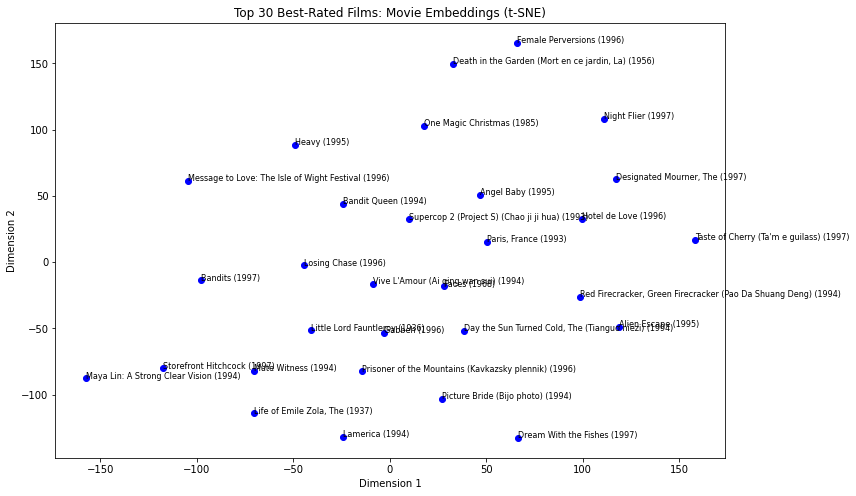

In [174]:
# get the movie titles for labeling
top_rated_movie_titles = movie_data[movie_data["movieId"].isin(top_rated_movie_ids)]["title"].tolist()

# plot the embeddings
plt.figure(figsize=(12, 8))
plt.scatter(top_rated_movie_embeddings_2d[:, 0], top_rated_movie_embeddings_2d[:, 1], marker="o", color="b")

# add labels to each point
for i, title in enumerate(top_rated_movie_titles):
    plt.annotate(title, (top_rated_movie_embeddings_2d[i, 0], top_rated_movie_embeddings_2d[i, 1]), fontsize=8)

plt.title("Top 30 Best-Rated Films: Movie Embeddings (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


### Dimensionality Reduction Approach - PCA

In [175]:
top_rated_movies = df.groupby("movieId")["rating"].mean().nlargest(30)
top_rated_movie_ids = top_rated_movies.index.tolist()

# get the embeddings for the top-rated movies
top_rated_movie_embeddings = model.movie_embedding(torch.LongTensor(top_rated_movie_ids)).detach().numpy()

In [176]:
from sklearn.decomposition import PCA

# apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2, random_state=42)
top_rated_movie_embeddings_2d = pca.fit_transform(top_rated_movie_embeddings)

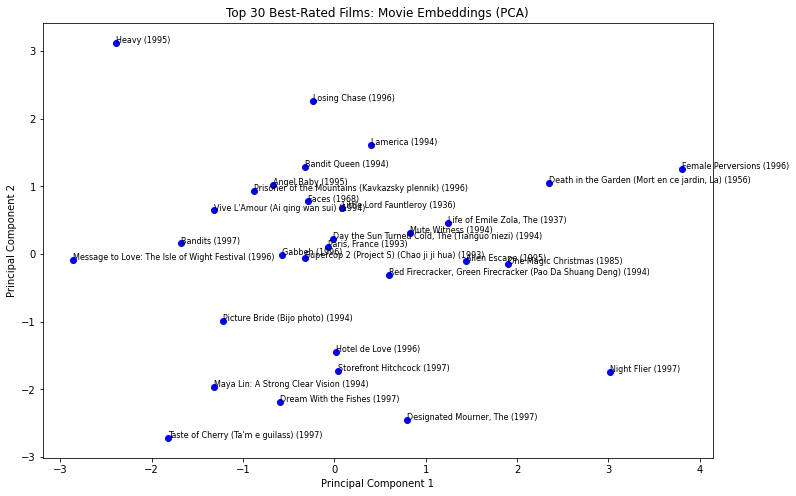

In [177]:
# get the movie titles for labeling
top_rated_movie_titles = movie_data[movie_data["movieId"].isin(top_rated_movie_ids)]["title"].tolist()

plt.figure(figsize=(12, 8))
plt.scatter(top_rated_movie_embeddings_2d[:, 0], top_rated_movie_embeddings_2d[:, 1], marker="o", color="b")

# add labels to each point
for i, title in enumerate(top_rated_movie_titles):
    plt.annotate(title, (top_rated_movie_embeddings_2d[i, 0], top_rated_movie_embeddings_2d[i, 1]), fontsize=8)

plt.title("Top 30 Best-Rated Films: Movie Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


### Filter more than one rating and plot the top 30 best rated films with PCA

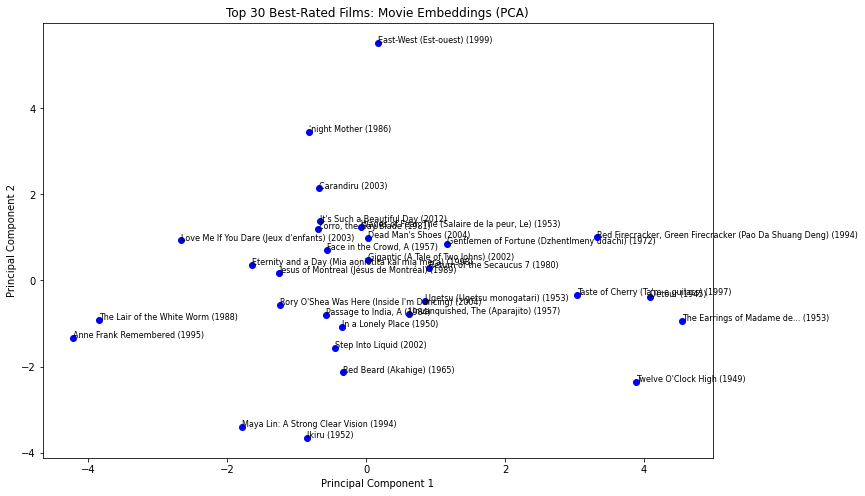

In [183]:
# filter movies with only one rating
filtered_movies = df.groupby("movieId").filter(lambda x: len(x) > 1)

top_rated_movies = filtered_movies.groupby("movieId")["rating"].mean().nlargest(30)
top_rated_movie_ids = top_rated_movies.index.tolist()

# filter the top_rated_movie_ids list
valid_movie_ids = [movie_id for movie_id in top_rated_movie_ids if movie_id in movie_id_to_index]

# convert valid movie IDs to movie indices
valid_movie_indices = [movie_id_to_index[movie_id] for movie_id in valid_movie_ids]

top_rated_movie_embeddings = model.movie_embedding(torch.LongTensor(valid_movie_indices)).detach().numpy()

pca = PCA(n_components=2, random_state=42)
top_rated_movie_embeddings_2d = pca.fit_transform(top_rated_movie_embeddings)

top_rated_movie_titles = movie_data[movie_data["movieId"].isin(valid_movie_ids)]["title"].tolist()

# plot the embeddings
plt.figure(figsize=(12, 8))
plt.scatter(top_rated_movie_embeddings_2d[:, 0], top_rated_movie_embeddings_2d[:, 1], marker="o", color="b")

# add labels to each point
for i, title in enumerate(top_rated_movie_titles):
    plt.annotate(title, (top_rated_movie_embeddings_2d[i, 0], top_rated_movie_embeddings_2d[i, 1]), fontsize=8)

plt.title("Top 30 Best-Rated Films: Movie Embeddings (PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()
